In [1]:
from os import listdir
from time import localtime
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [2]:
mpl.rcParams.update({'font.size': 22})

TOC
1. Краткое подведение итогов
2. Анализ данных
    1. Методы каротажа
        1. Методы электрического каротажа
            1. Группа методов кажущегося сопротивления (КС) собственно
            2. Группа электромагнитных методов
            3. Группа методов электрохимической активности
        2. Методы радиоактивного каротажа
            1. Группа гамма-методов
    2. Utility fuctions
    3. Загрузка данных
        4. Загрузка расшифровки литологий
        5. Загрузка скважин
    4. Анализ скважин
        1. Графики корреляций методов в различных скважинах
        2. Куст скважин
        3. Распределения переменных
        4. Анализ гистограм интервалов относительно значений целевой переменной
        5. Распределения целевой переменной
3. Обучение
    1. Baseline algorithm (count classifier)
    2. Разбиение на train/dev/test sets
        1. Отсутвующие методы
        2. Выборка без отсутвующих методов
        3. Обучение методов
            1. Random Forest
            2. LogisticRegression
            3. Count classifier
            4. Выводы:
        4. Заполнить пропущенные методы и значнеия средним по датасету
            1. Обучение методов
                1. Random Forest
                2. LogisticRegression
        5. Заполнить пропущенные методы и значнеия "нулями"
            1. Обучение методов
                2. Random Forest
                3. LogisticRegression
        6. Заполнение пропущенных значений аппроксимацией
            1. Построение аппроксимирующей модели
            2. Train/test split
            3. Обучение методов
                1. Random Forest
                2. LogisticRegression
            4. Выводы:

 Краткое подведение итогов:
- На данном этапе, лучше всего работает отбрасывание отсутствующих значений.
- Различные методы замещения "нулей" работают плохо.
    - На что стоит обратить внимание:
        - **Выборка без отсутвующих методов**
            - Результаты классификации с помощью Random Forest и Logistic Regression показывают, что необходимо использовать понижение количества наблюдаемых занчений (Under sampling)
            - Стоит добавить:
                - Кросс валидацию с one deposit out;
                - Under sampling
                - Попробовать альтернативные методы классификаци
        - **Заполнить пропущенные методы и значнеия средним по датасету**
            - Заполение средними значениями дает не очень хорошие результаты. Скорее всего, дело в том, что:
                - на разной глубине разные значения методов;
                - Мы добавляем еще больше больше лишних значений (в частности песка), поэтому разумно было бы использовать undersampling
        - **Заполнить пропущенные методы и значнеия "нулями"**
            - Заполение "нулями" вообще не работает хд
            - Поэтому для них надо искать замену либо вообще их удалять
        - **Заполнение пропущенных значений аппроксимацией**
            
            К сожалению, магия не случилась и точность не повысислась.

            Но тут может быть другая проблема быть причиной:
            - При моделировании методов, коефиициент детерминации во многих случаях очень маленький, поэтому имеет смысл обратить на это внимание.
                - Поиграть с масштабом данных;
                - Попробовать иные методы нелинейной регрессии.
            - Мы также добавляем еще больше лишних значений для и так большого количества литологий, мб в этом проблема.
            
Итог такой: Даные в любом случае надо чистить. Поскольку только избавление от пропущенных значений повышает точность. Имеет смысл также попробовать визуализировать данные после заполнения с помощью TSNE. Также стоит, как уже было неоднократно сказано, применить undersampling.

# Анализ данных

## Методы каротажа
[wiki_link](https://ru.wikipedia.org/wiki/Каротаж)
### Методы электрического каротажа
#### Группа методов кажущегося сопротивления (КС) собственно 
- Единица ПС измерения – милливольт (мВ)
- **КС** — кажущееся сопротивление с нефокусированными зондами. Самый распространённый метод данной группы, являющийся скважинным аналогом метода электрического профилирования в электроразведке
- **резистивиметрия (REZ)**. С помощью этого метода измеряют удельное электрическое сопротивление жидкости, заполняющей в данный момент скважину. Жидкость может быть представлена как буровым раствором (его сопротивление заранее известно), так и пластовыми флюидами (нефть, пресная или минерализованная вода), а также их смесью
- **БКЗ** — боковое каротажное зондирование. Данный метод является скважинным аналогом метода вертикального электрического зондирования в электроразведке
- **микрокаротаж** — разновидность КС с зондами очень малого размера, вплотную прижимаемыми к стенкам скважины. С помощью данного метода, преимущественно, ищут только коллекторы по скважине
- **БК** — боковой каротаж. Отличие от классического КС заключается в фокусировке тока зондом
- **МБК** — микробоковой каротаж. Отличие данного метода от микрокаротажа заключается в фокусировке тока зондом

#### Группа электромагнитных методов
Основное преимущество данной группы методов заключается в том, что их возможно использовать в сухих скважинах, не заполненных токопроводящим буровым раствором. Кроме того, его возможно применять и в скважинах, заполненных буровым раствором на основе нефти, которые тоже не проводят постоянный электрический ток. Встречаются следующие разновидности:

- **ИК** — индукционный каротаж. При проведении используют сравнительно низкие частоты — до 200 кГц<br>
индукционный каротаж на высоких частотах, результаты которого зависят как от электропроводности пород, так и от их диэлектрической проницаемости:
- **ВМП** — волновой метод проводимости с частотой 1-5 МГц
- **ВДК** — волновой диэлектрический каротаж с частотой до 60 МГц
- **ВЭМКЗ** - высокочастотное электромагнитное каротажное зондирование
- **ВИКИЗ** — высокочастотное индукционное каротажное изопараметрическое зондирование. Метод является аналогом БКЗ, но вместо постоянного тока используется переменный

#### Группа методов электрохимической активности
- **ПС** — метод самопроизвольной поляризации, также известный как метод потенциалов самопроизвольной поляризации. Является скважинным аналогом метода естественного поля в электроразведке
- **ЭК** — электролитический каротаж. Скважинный аналог метода вызванной поляризации в электроразведке
- **МЭП** — метод электродных потенциалов. Данный метод существует исключительно в скважинном варианте и не имеет аналогов в полевой электроразведке

### Методы радиоактивного каротажа
#### Группа гамма-методов
- **ГК** — гамма-каротаж. Очень простой и распространённый метод, измеряющий только естественное гамма-излучение от пород, окружающих скважину. Существует его чуть более усложнённый вариант — спектрометрический гамма-каротаж (СГК или ГК-С), который позволяет различить попавшие в детектор геофизического зонда гамма-кванты по их энергии. По этому параметру можно точнее судить о характере слагающих толщу пород. 
    - Основная расчетная величина – мощность экспозиционной дозы в микрорентгенах в час (МЭД, мкР/ч). Измеряемая величина определяется концентрацией, составом и пространственным распределением ЕРЭ, плотностью ρп и эффективным атомным номером Zэфф пород. Гамма-каротаж
    - Входит в число обязательных методов
    - 
- **ГГК** — гамма-гамма каротаж. Геофизический зонд облучает породу гамма-излучением, в результате которого порода становится радиоактивной и в ответ тоже излучает гамма-кванты. Именно эти кванты и регистрируются зондом. Существует две основных разновидности метода:
    - плотностная — ГГК-П (иногда встречается обозначение ПГГК)
    - селективная — ГГК-С (может обозначаться как Z-ГГК, С-ГГК и т. п.)
- **РРК** — рентгенорадиометрический каротаж. Его название формально не соответствует общепринятой системе, поэтому иногда встречается название ГРК (гамма-рентгеновский каротаж), но РРК является общеупотребимым.


## Utility fuctions

In [3]:
def load_dtfs(path='../data/digdes-data/coal-wells-2/', zeros=-999.25):
    """
    Load wells as a dict with their file names
    """
    csvs = [file for file in listdir(path) if file.endswith('.csv')]
    dtfs = dict()
    for csv in csvs:
        dtf = pd.read_csv(path + csv, sep=';', decimal=',', encoding='cp1251')
        dtf[dtf == zeros] = np.nan
        dtf[dtf == -9999] = np.nan
        if 'REZ' in dtf.columns:
            dtf.REZ[dtf.REZ < 0] = np.nan
        dtf.LIT
        dtfs[csv[:-4]] = dtf
    return dtfs

In [4]:
## Try to convert data to float to find bullshit
def check_values_multiple_comas(dtfs, column):
    """
    Pass dictionary of dataframes to find bad dataframe and value
    """
    for name, dtf in dtfs.items():
        for val in dtf[column]:
            try:
                if type(val) == str:
                    float(val.replace(',', '.'))
            except:
                print(name, val)

In [93]:
def check_values_for_str(dtf, column, name):
    for val in dtf[column]:
        try:
            if type(val) == str:
                float(val)
        except:
            print(name, val)

In [6]:
def generate_file_name(extension, f_name=''):
    """generate file name with `extension`"""
    tm = localtime()
    name = f_name + '-' + '-'.join(map(str, [tm.tm_year, tm.tm_mon, tm.tm_mday, tm.tm_hour, tm.tm_min, tm.tm_sec])) + extension
    return name

In [7]:
def plot_conusion_matrix(matrix, ticks='auto', normalized=True, plot=True, 
                         save_fig=True, save_path='', file_name='', extension='.png',
                         **kwargs):
    """
    function to plot, print and save confusion matrix
    :params:
        matrix     -- calculated confusion matrix
        ticks      -- class labels
        normalized -- (bool) normalize or not matrix
        plot       -- (bool) plot or print matrix
        save_fig   -- (bool) save figure or not to `save_path`
        save_path  -- (str) path to save figure. if None, saves to directory of function call.
        file_name  -- (str) name of figure with extension
        **kwargs   -- parameters for sns.heatmap
    """
    if normalized:
        mat = matrix/(np.sum(matrix, axis=1).reshape(-1, 1))
    else:
        mat = matrix
    if plot:
        sns.heatmap(mat, annot=True, xticklabels=ticks, yticklabels=ticks, **kwargs)
        plt.tight_layout()
        if save_fig:
            name = generate_file_name(extension, file_name)
            plt.savefig(join(save_path, name))
    else:
        print(mat)

In [8]:
def plot_correlations_in_well(dtf, name, axis=None):
    sns.heatmap(dtf.corr(), annot=True, ax=axis)
    if axis:
        axis.set_title('dtf_{}'.format(name))
    else:
        plt.title('dtf_{}'.format(name))

In [9]:
def indices_with_swaps(shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            yield i, j

In [10]:
def plot_correlations_in_deposit(dtf_dict, figsize=(20, 20)):
    plot_shape = (int(np.ceil(np.sqrt(len(dtf_dict)-1))), 
                  int(np.ceil(np.sqrt(len(dtf_dict)-1))))
    
    indices = indices_with_swaps(plot_shape)
    fig, axis = plt.subplots(plot_shape[0], plot_shape[1], figsize=figsize, sharex=False, sharey=False)
    for name, dtf in dtf_dict.items():
        ind = next(indices)
        plot_correlations_in_well(dtf, name, axis[ind[0], ind[1]])

## Загрузка данных

### Загрузка расшифровки литологий

In [11]:
data_source = 'data/digdes-data/'

In [12]:
lithology = pd.read_excel(data_source + 'coal-wells-1/Литология.xlsx')
lithology.index = lithology['Литология'].values
lithology.drop(['Литология'], inplace=True, axis=1)
lithology = lithology.to_dict()['порода ']

In [13]:
lithology

{1: 'песчаник',
 2: 'Аргиллит алевритовый',
 3: 'Аргиллит',
 4: 'Гравелит ',
 5: 'алевролит',
 6: 'Аргиллит углистый',
 7: 'Уголь',
 8: 'Супесь ',
 9: 'Суглинок',
 10: 'Валунно-галечные отложения',
 11: 'песок'}

In [14]:
def print_value_counts_maped(dtf, val):
    for v, k in dtf[val].value_counts().items():
        if v in lithology.keys():
            print('{} : {}'.format(lithology[int(v)], k))
        else:
            print('{} : {}'.format(v, k))

### Загрузка скважин

In [15]:
## Loading dataframes
dtfs_first = load_dtfs(data_source + 'coal-wells-2/first-bath/')
dtfs_second = load_dtfs(data_source + 'coal-wells-2/second-bath/')

print('Количество скважин в первом и во втором местрождении: {} и {}'.format(len(dtfs_first), len(dtfs_second)))

/home/nikita/projects/carrot/venv/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Количество скважин в первом и во втором местрождении: 24 и 28


In [ ]:
dtf_first.LIT.

In [16]:
## Concating dataframes
dtf_first = pd.concat([d for d in dtfs_first.values()], ignore_index=True)
dtf_second = pd.concat([d for d in dtfs_second.values()], ignore_index=True)

In [17]:
print('Количество данных в первом месторождении с отсутствующими значениями {} и без них {}'.format(dtf_first.shape[0], dtf_first.dropna().shape[0]))
print('Количество данных во втором месторождении с отсутствующими значениями {} и без них {}'.format(dtf_second.shape[0], dtf_second.dropna().shape[0]))

Количество данных в первом месторождении с отсутствующими значениями 352137 и без них 41447
Количество данных во втором месторождении с отсутствующими значениями 171512 и без них 0


В первом местрождении столько значений пропадает из-за того, что в некоторых скважинах отсутвуют некоторые методы каротажа

In [75]:
print('Методы каротажа в первом и во втором месторождении')
for f, s in zip(sorted(dtf_first.columns), sorted(dtf_second.columns)):
    print(f, s)

Методы каротажа в первом и во втором месторождении
BK BK
DS DS
Dept DT
GGK(p) Dept
GR GGK(p)
KS GR
LIT KS
REZ LIT


Месторождения различаются в два метода:
- В первом присутствует KS
- Во втором DT

## Анализ скважин

### Графики корреляций методов в различных скважинах

Корреляции в первом меторождении

In [19]:
mpl.rcParams.update({'font.size': 12})

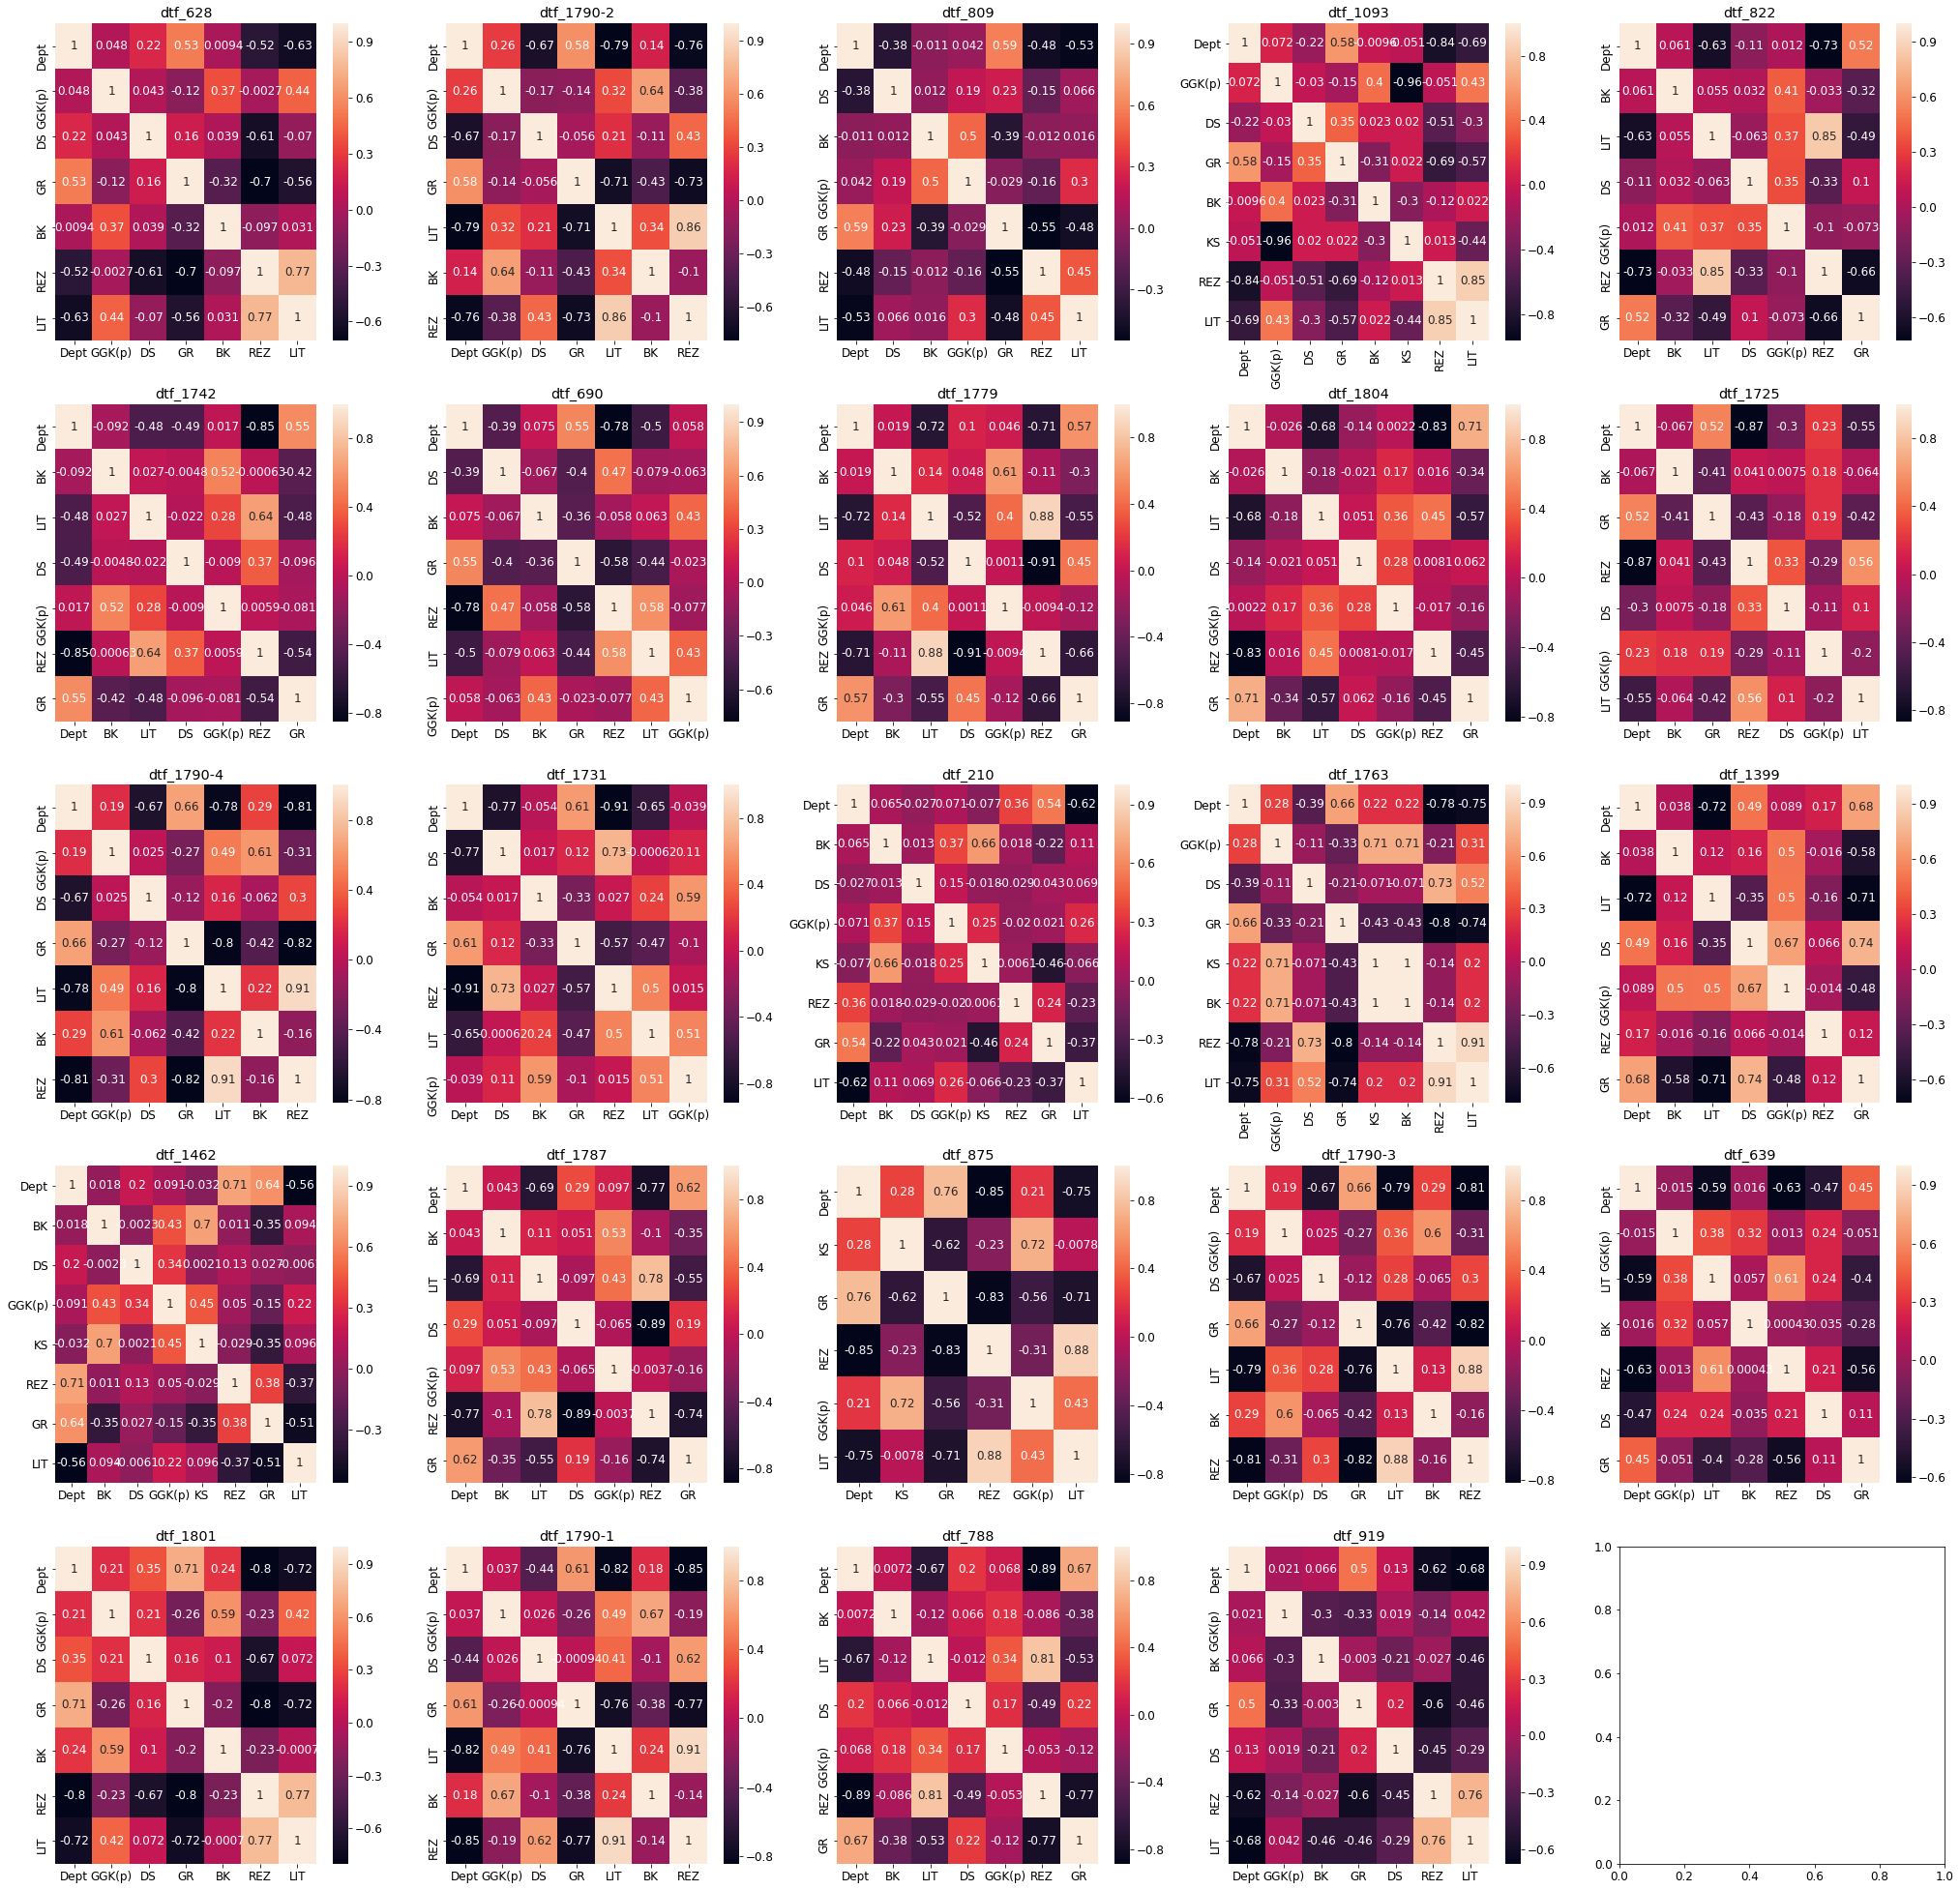

In [77]:
plot_correlations_in_deposit(dtfs_first, figsize=(35, 35))

Корреляции во втором меторождении

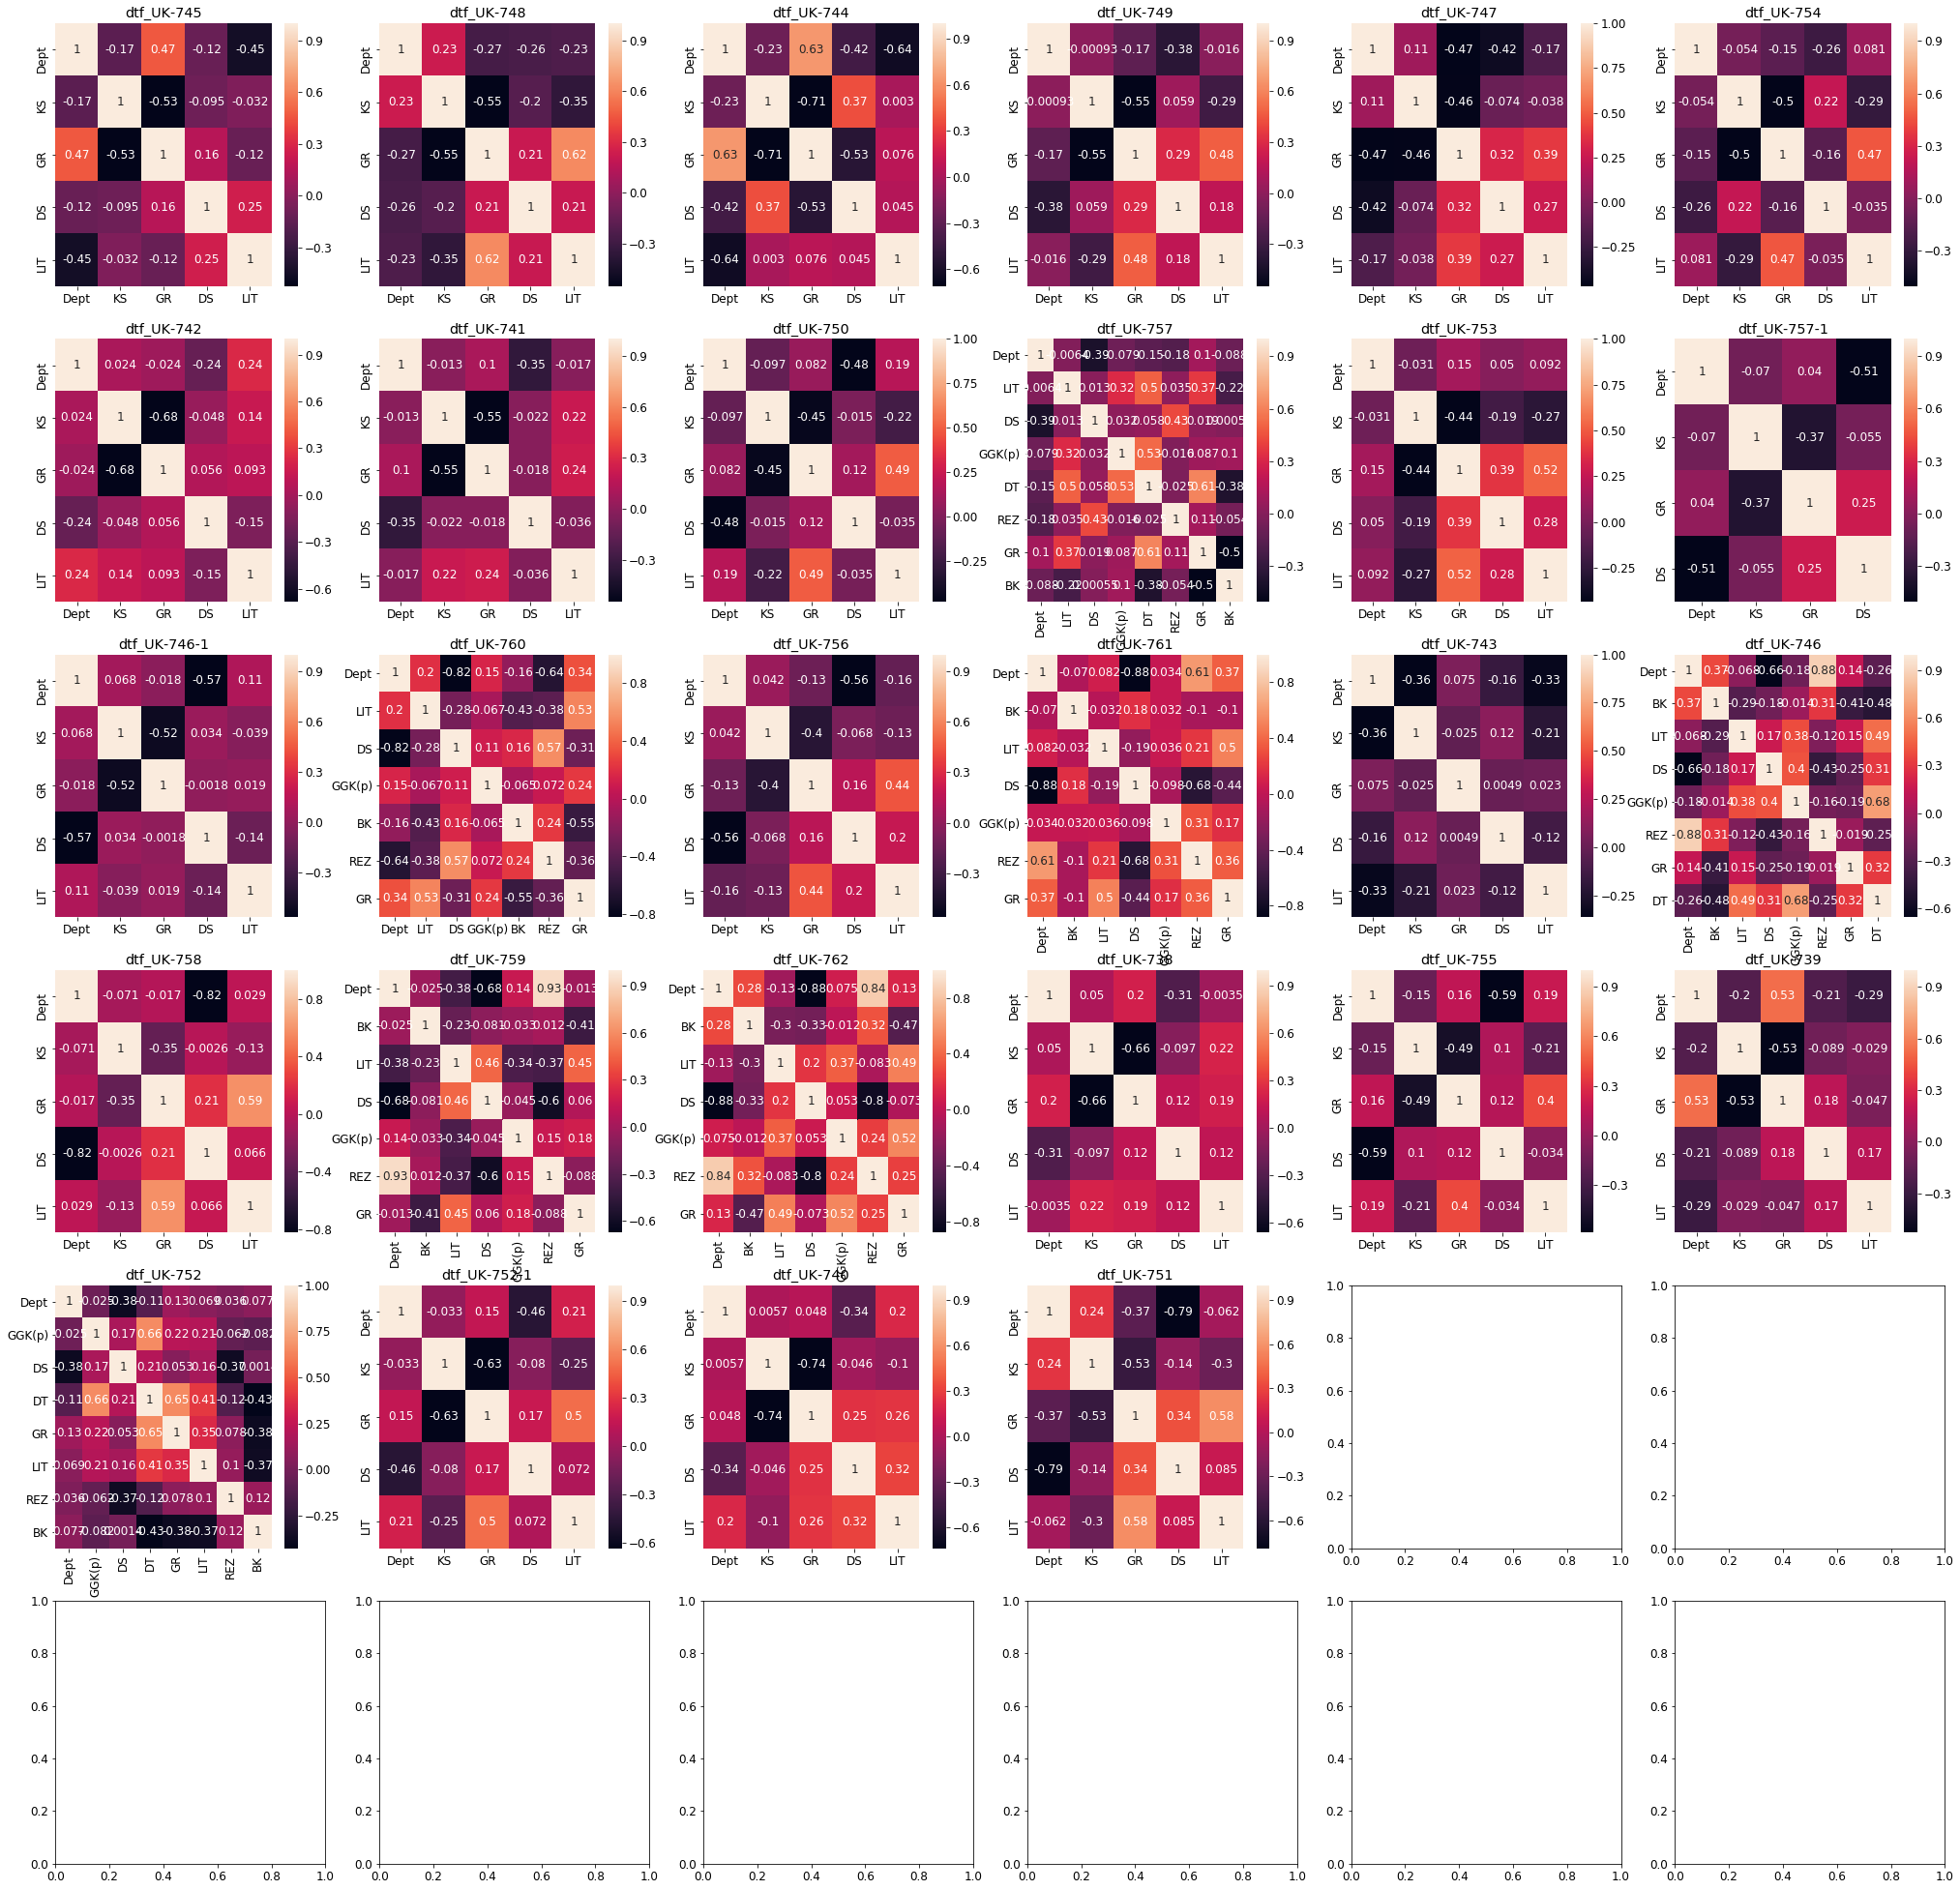

In [79]:
plot_correlations_in_deposit(dtfs_second, figsize=(35, 35))

- В Первом месторождении в скважине 875 не показывает корреляцию `LIT`

### Куст скважин
[wiki_link](https://www.google.ru/search?q=%D0%BA%D1%83%D1%81%D1%82+%D1%81%D0%BA%D0%B2%D0%B0%D0%B6%D0%B8%D0%BD&newwindow=1&client=safari&rls=en&dcr=0&tbm=isch&source=iu&pf=m&ictx=1&fir=9ca7KdUffmDkkM%253A%252CxWarwb_k1F4EHM%252C_&usg=__koPjYzig1ThzCyw5PTk-gc2FicY%3D&sa=X&ved=0ahUKEwiElrvMtu3WAhUiOpoKHXORApkQ9QEIKTAA#imgrc=9ca7KdUffmDkkM:)

![well bush](https://cf.ppt-online.org/files/slide/9/96mRjBA5p1MoiZyCqOQFEYtc3I8LeSv4dWufhJ/slide-4.jpg)

Скважины `1790-*` -- образуют куст скважин. Как видно на изображении, не сильно отдалены, поэтому, пожно предположить, что данные в этих скважинах будут коррелировать

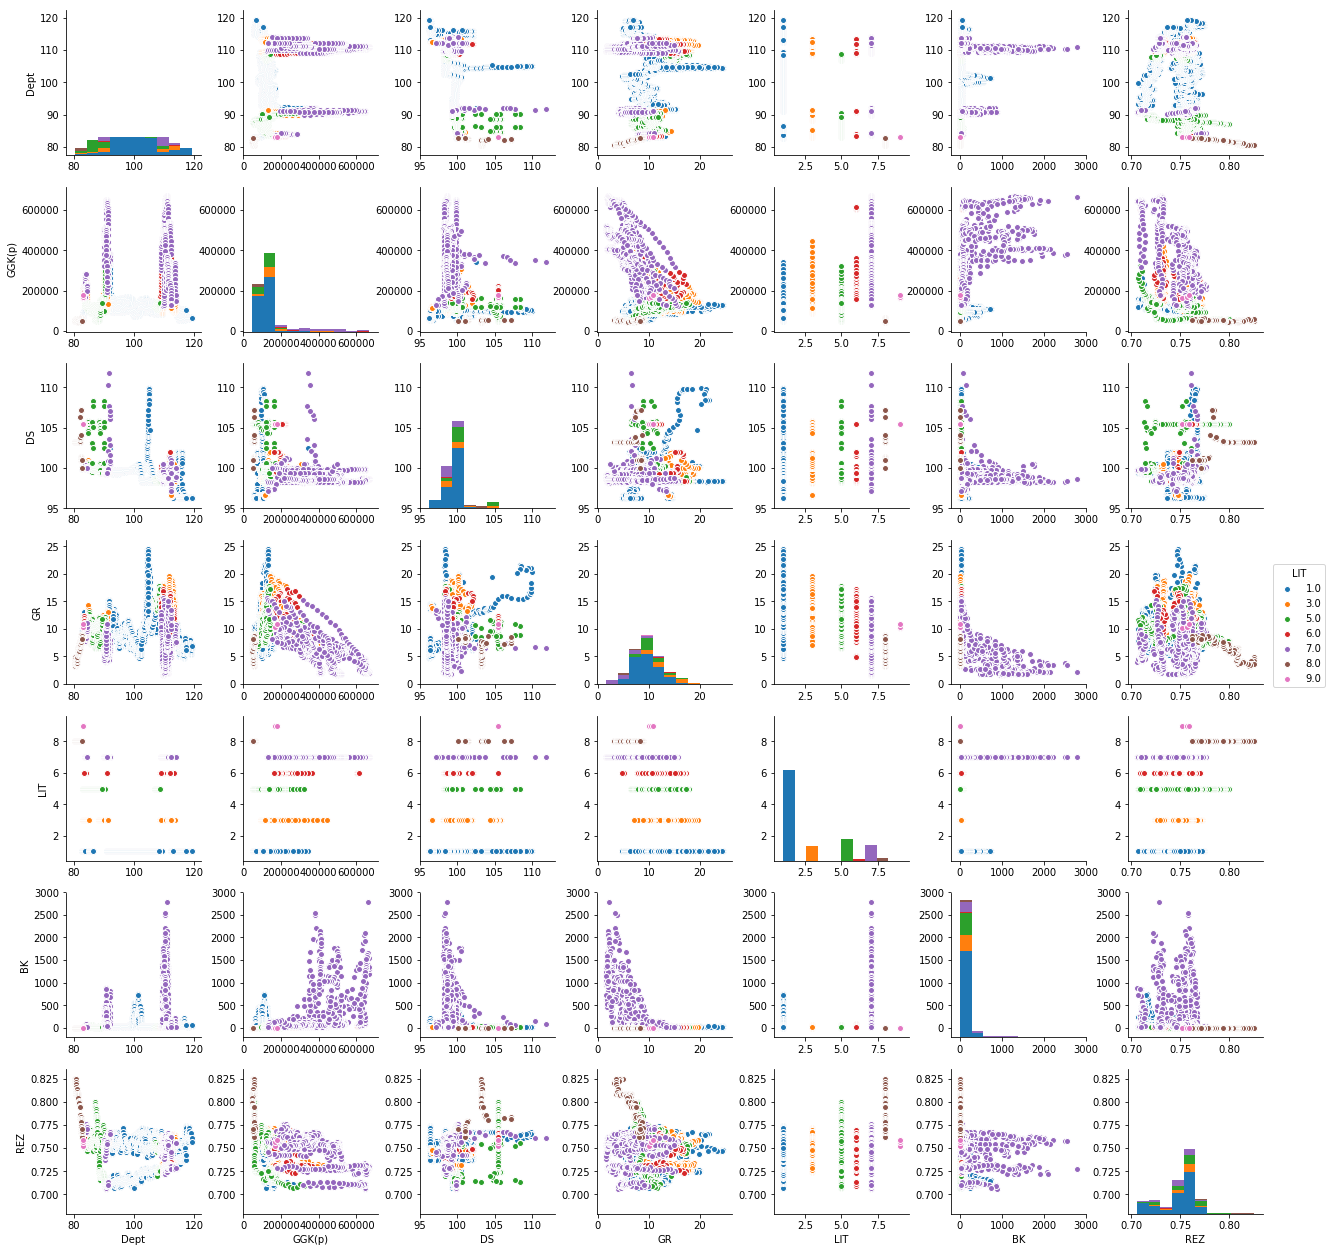

In [154]:
sns.pairplot(pd.concat([dtfs_first['1790-1'].dropna(), dtfs_first['1790-2'].dropna(), 
                        dtfs_first['1790-3'].dropna(), dtfs_first['1790-4'].dropna()], 
                       ignore_index=True), hue='LIT')

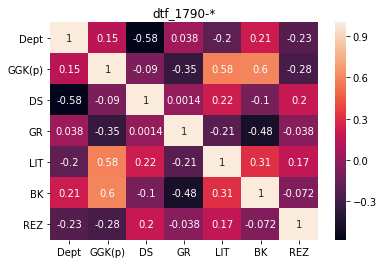

In [155]:
plot_correlations_in_well(pd.concat([dtfs_first['1790-1'].dropna(), dtfs_first['1790-2'].dropna(), 
                                     dtfs_first['1790-3'].dropna(), dtfs_first['1790-4'].dropna()], 
                                    ignore_index=True),
                          name='1790-*')

### Распределения переменных

Распределение первенных в первом месторождении

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12267cc18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115c2f588>]], dtype=object)

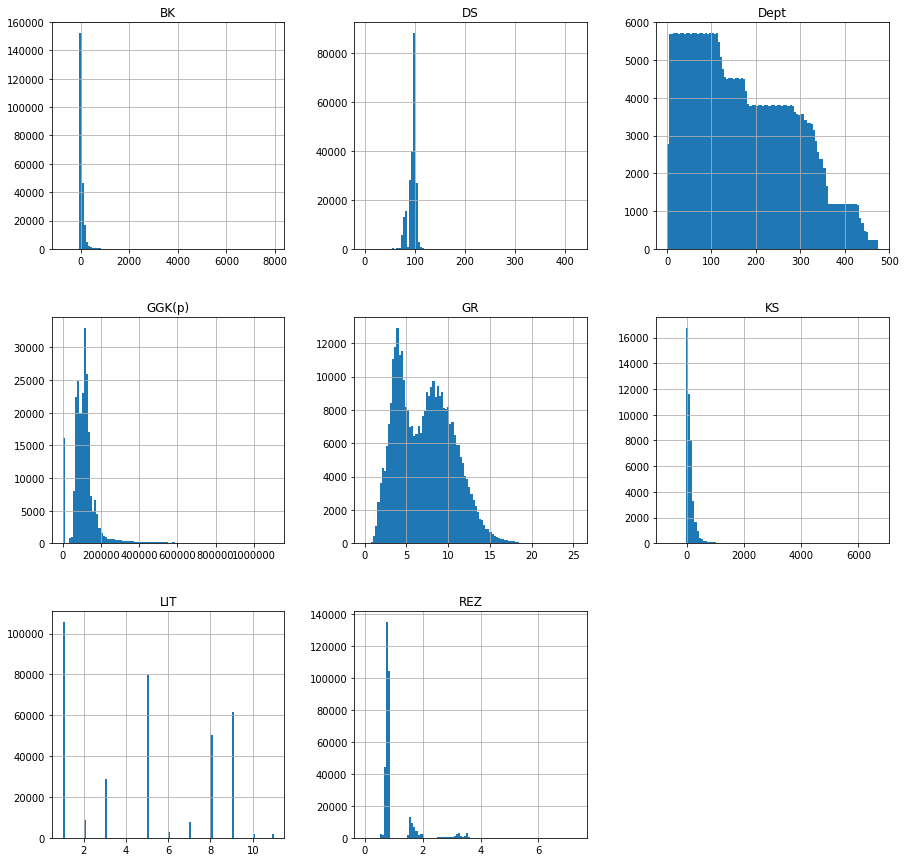

In [158]:
dtf_first.hist(bins=100, figsize=(15, 15))

Распределение первенных во втором месторождении

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1147173c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ac51cc0>]], dtype=object)

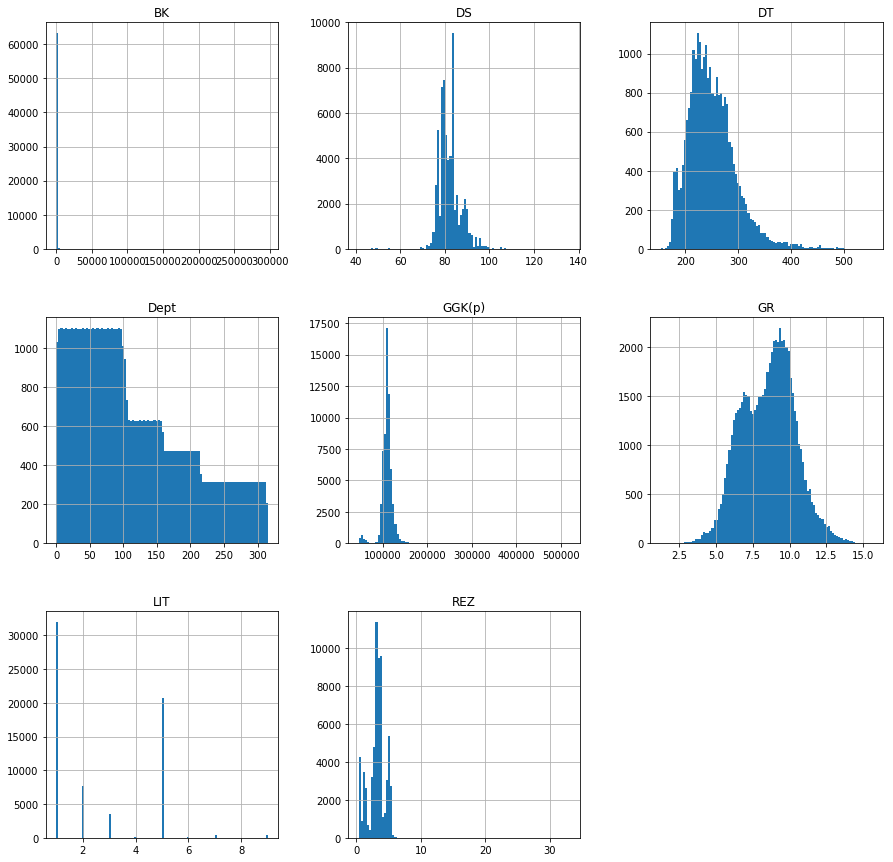

In [159]:
dtf_second.hist(bins=100, figsize=(15, 15))

Видно, что у `GK` есть два пика. Первое, что приходит в голову, проверить эмпирику геофизика, что данные в первых 100 метрах не играют роли.

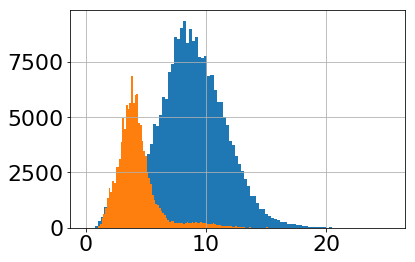

In [18]:
dtf_first.GR[dtf_first.Dept >= 100].hist(bins=100)
dtf_first.GR[dtf_first.Dept < 100].hist(bins=100)

Получается, что действительно, стоит брать данные, которые глубже 100 метров. 

Однако обсуждая это явление, вяснилось, что эти 100 метров есть не всегда, иногда глубже, а иногда вообще нет. Поэтому в конечном приложении имеет смысл дать пользователю выбирать, с какой глуины он хочет начать

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123fc9dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1251ea828>]], dtype=object)

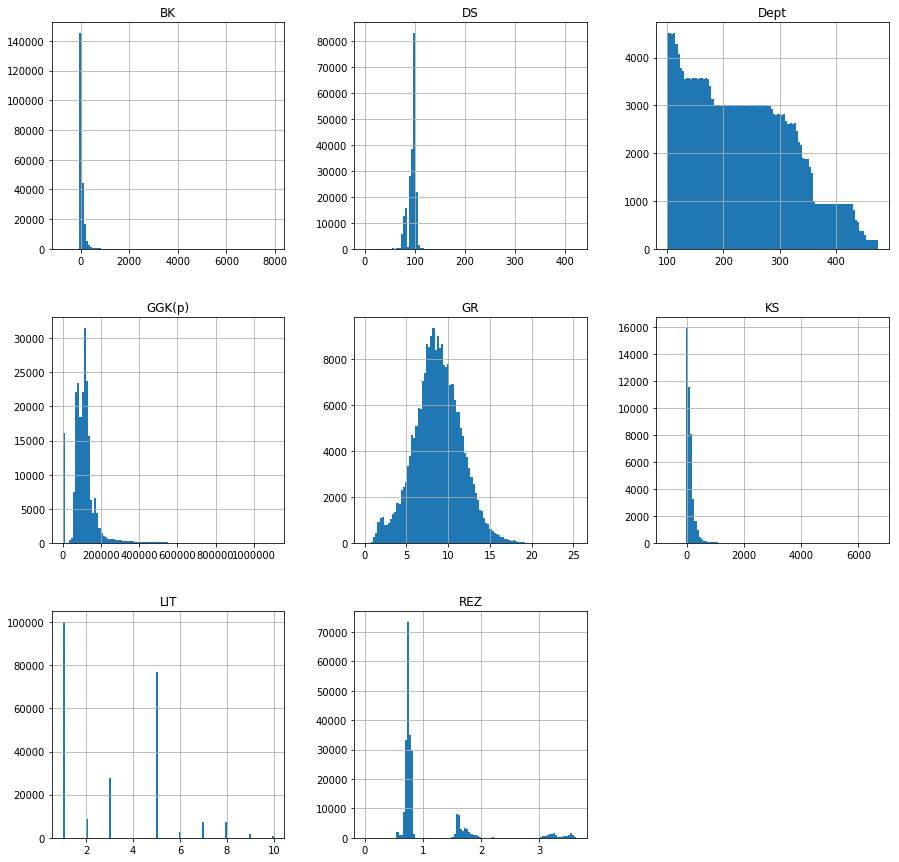

In [164]:
dtf_first[dtf_first.Dept >= 100].hist(bins=100, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12533af28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e0aeb70>]], dtype=object)

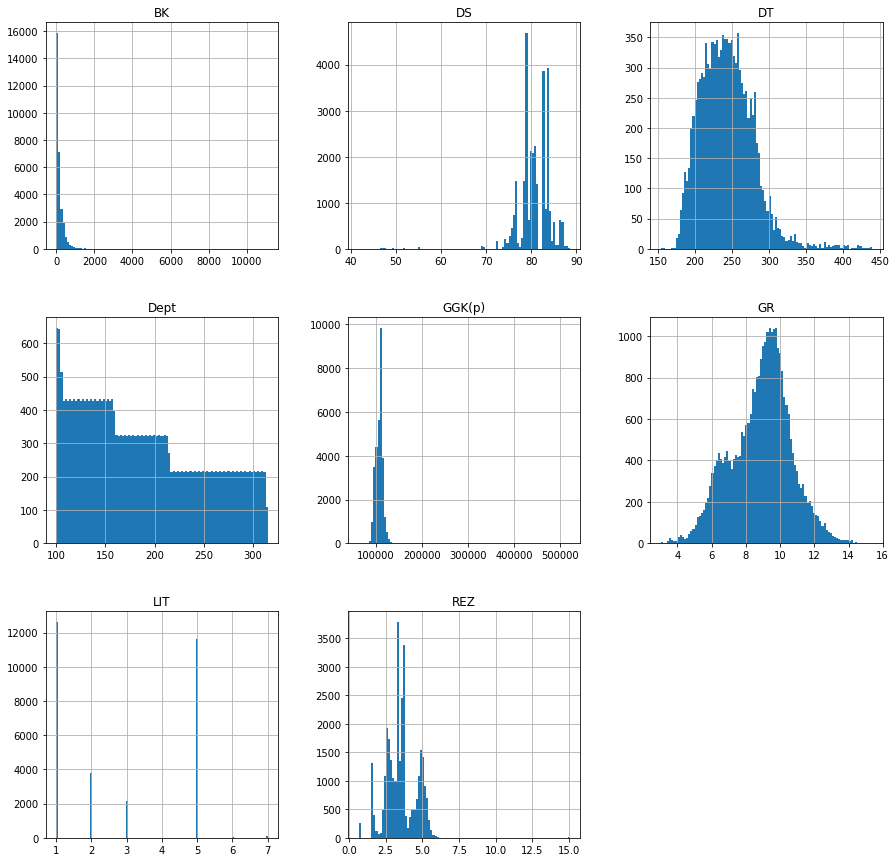

In [165]:
dtf_second[dtf_second.Dept >= 100].hist(bins=100, figsize=(15, 15))

### Анализ гистограм интервалов относительно значений целевой переменной

In [30]:
mpl.rcParams.update({'font.size': 12})

In [28]:
def plot_histograms_for_target_variables(dtf, save_name=None, figsize=(30, 30), with_names=True):
    """
    fucntion to plot distribution of variables for every value of lithology. 
    save_name -- (str) -- file name and where to save plot
    dtf -- dataframe with `LIT` column
    with_names -- (bool) -- plot with target variables as numbers or target variabeles as actual names
    
    :returns: (Series) value_counts
    """
    counts = dict()
    
    for lit in dtf.dropna().LIT.unique():
        if not pd.isnull(lit):
            descr = dtf.dropna()[dtf.dropna().LIT == lit]
            intervals = dict()
            for v in descr.columns:
                intervals[v] = descr[v].values
            if with_names:
                counts[lithology[lit]] = intervals
            else:
                counts[lit] = intervals
    if with_names:
        fig, axis = plt.subplots(len(counts), len(counts[lithology[1]]), figsize=figsize)
    else:
        fig, axis = plt.subplots(len(counts), len(counts[1]), figsize=figsize)
    for i, val_d in enumerate(counts.items()):
        for j, val in enumerate(val_d[1].items()):
            axis[i, j].hist(val[1], bins=20)
            axis[i, j].set_title('{} lithology, {} method'.format(val_d[0], val[0]))
            
#     plt.tight_layout()
    if save_name:
        plt.savefig(save_name)

    return counts

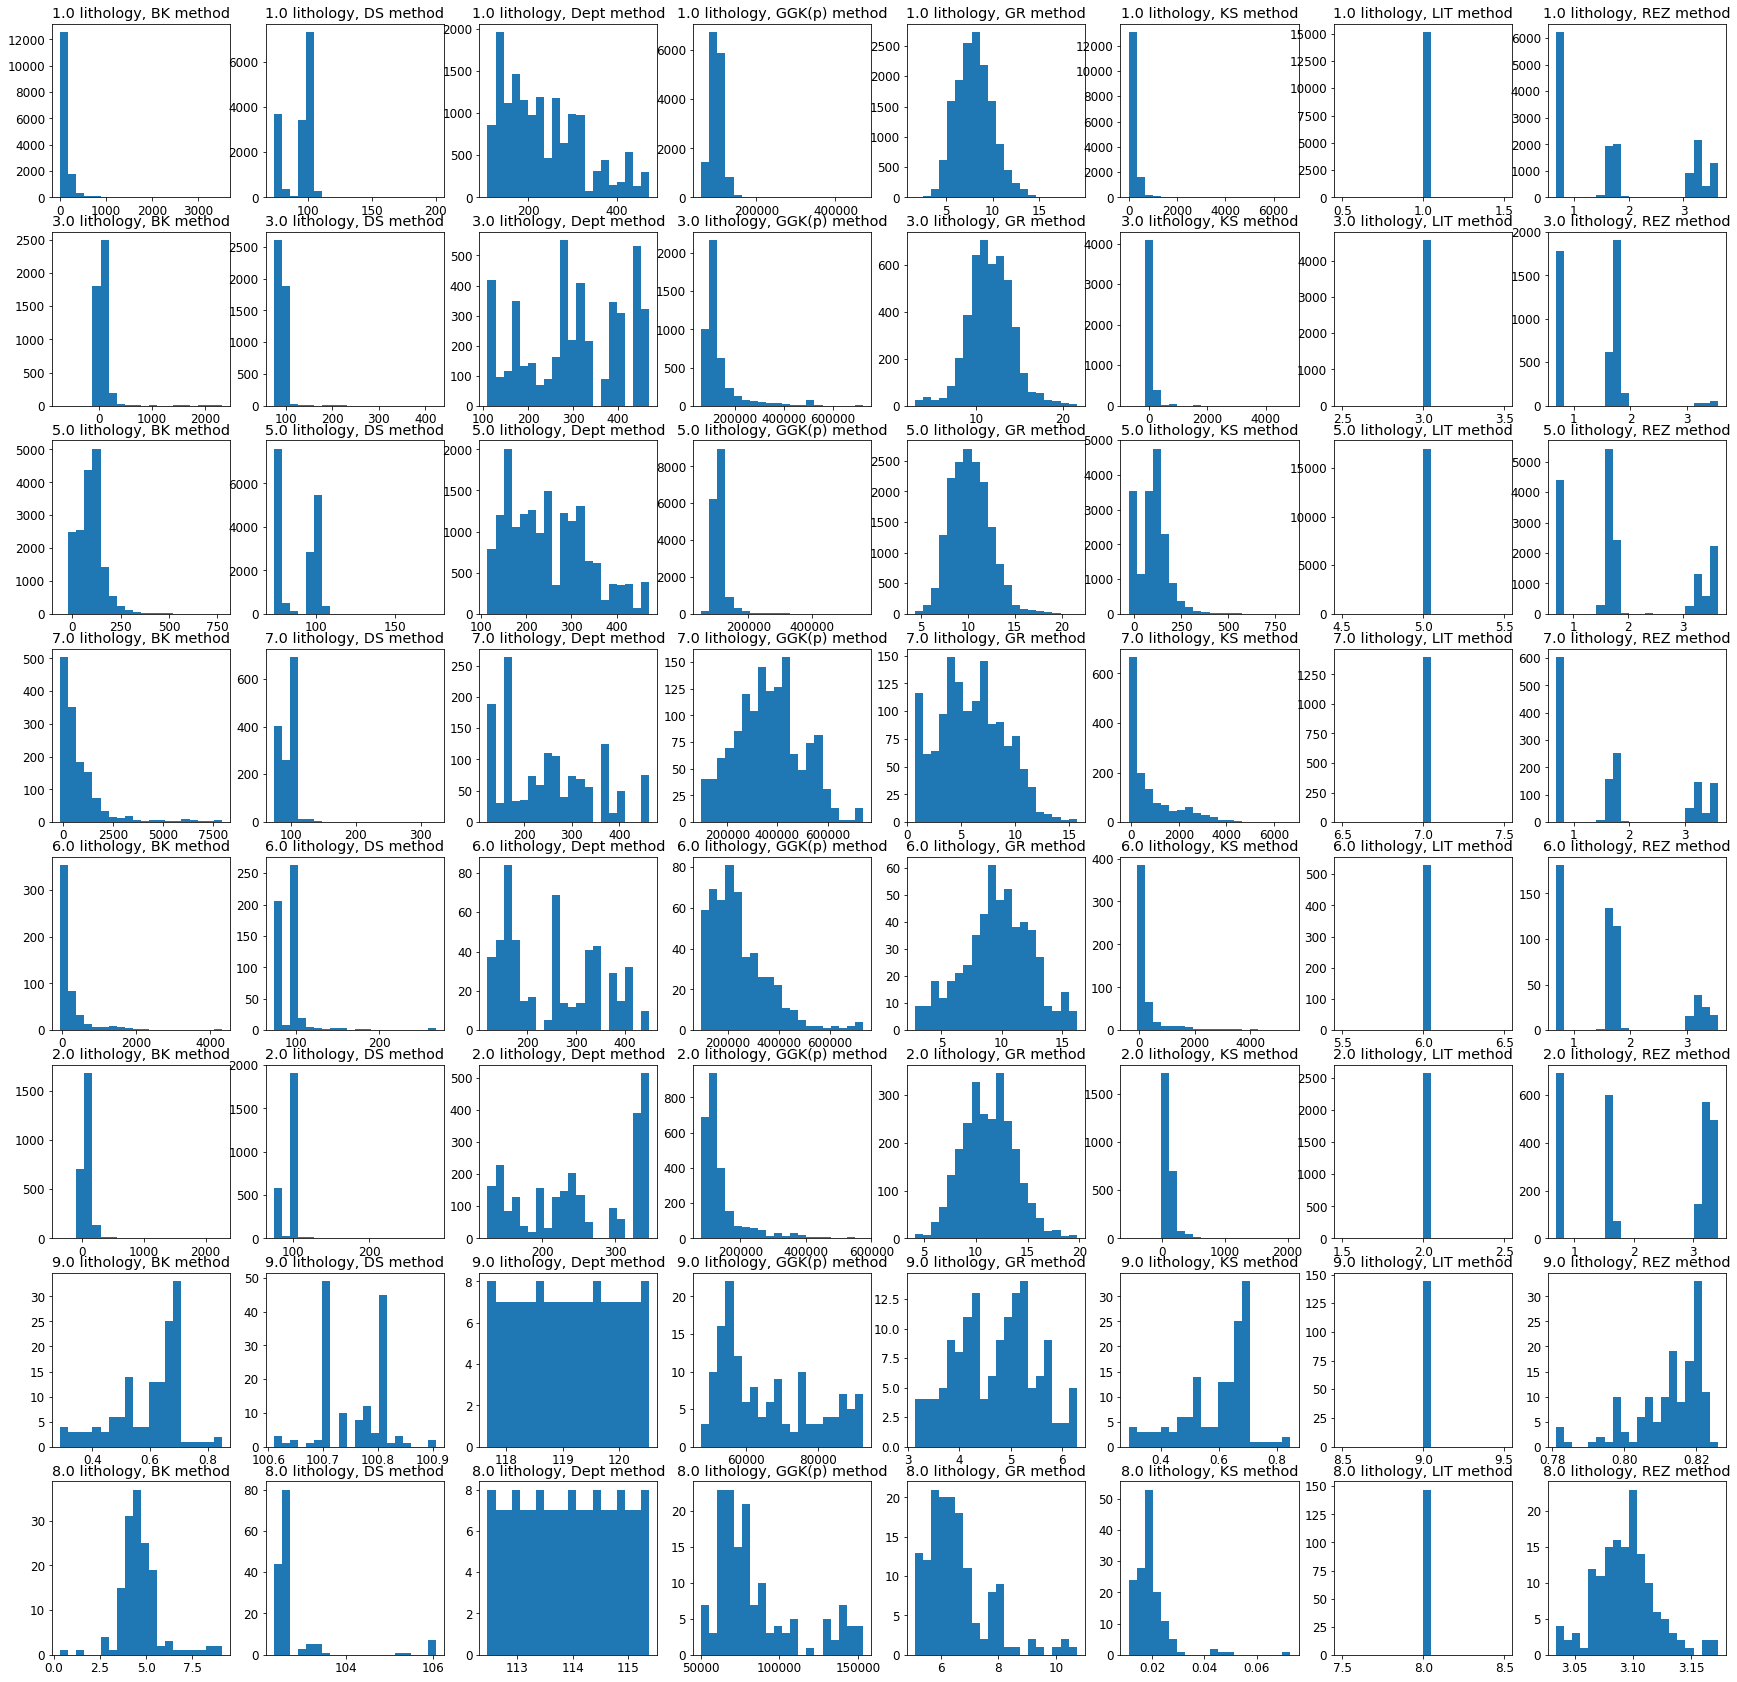

In [31]:
counts = plot_histograms_for_target_variables(dtf_first, save_name='log-images/target-and-observe-vars-first-dtf.png',
                                             with_names=False)

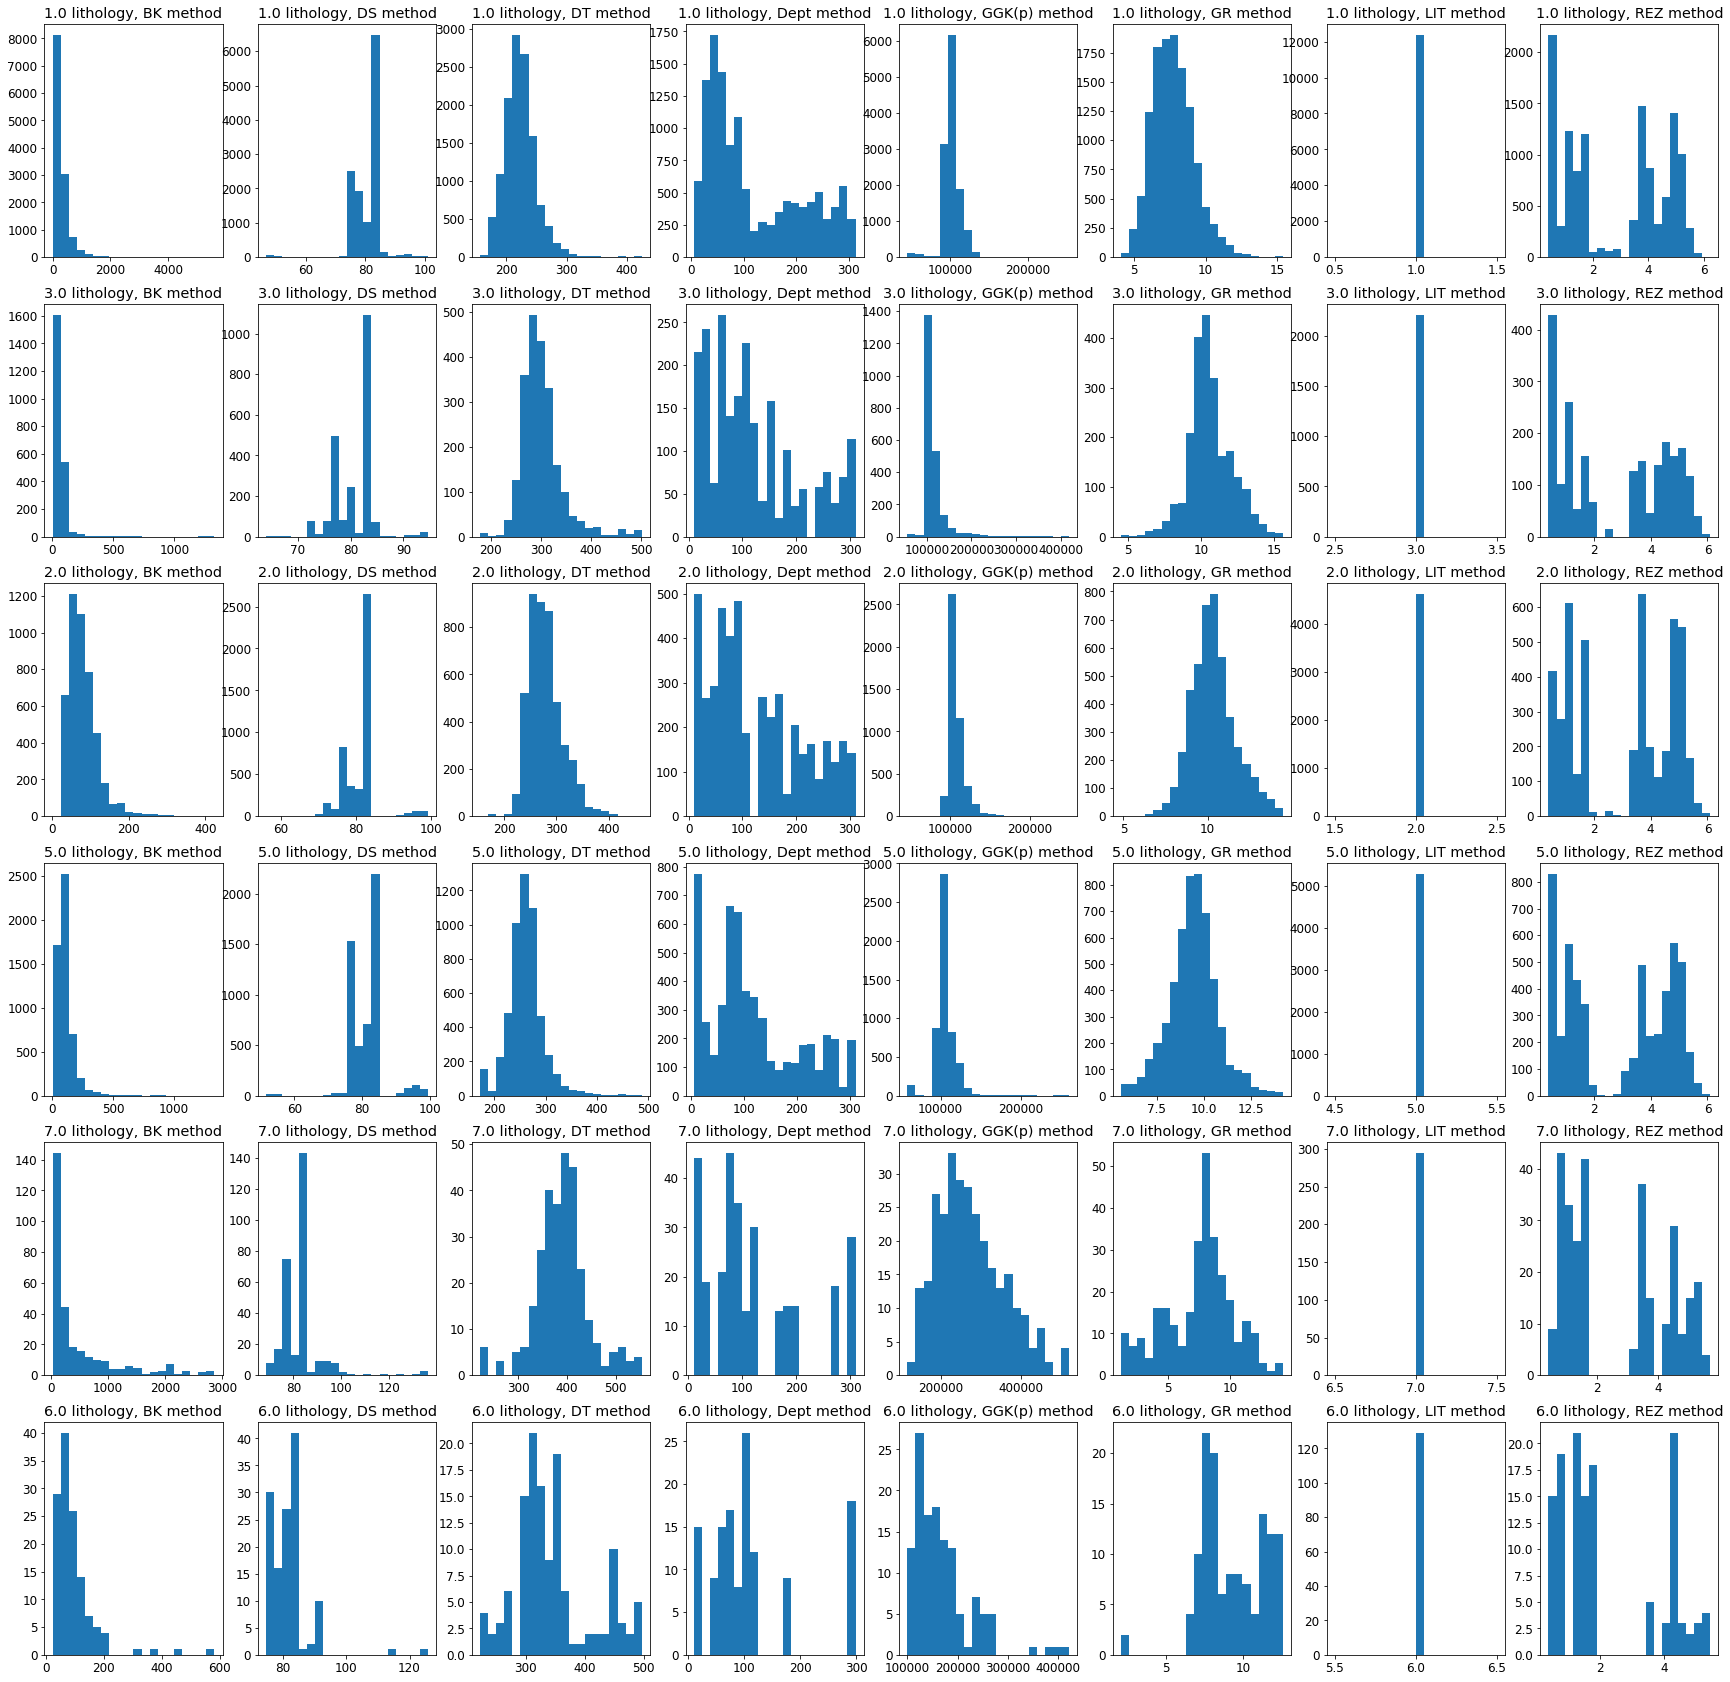

In [149]:
counts = plot_histograms_for_target_variables(dtf_second, save_name='log-images/target-and-observe-vars-second-dtf.png',
                                             with_names=False)

- GR Подчиняется нормальному распределению
- GGK похожа на нормальное, но имеет тяжелые хвосты, а также выбросы
- KS и BK похожи на распределние Пуассона, за некоторым исключением

В итоге, можно будет попробовать отбрасывать шумовые значения по правилу 2-х сигм

### Распределения целевой переменной

In [170]:
dtf_first['LIT'].value_counts()

1.0     105632
5.0      79680
9.0      61533
8.0      50142
3.0      28757
2.0       8555
7.0       7821
6.0       2926
11.0      2076
10.0      1969
Name: LIT, dtype: int64

/home/nikita/projects/carrot/venv/lib/python3.5/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: unorderable types: float() < str(), sort order is undefined for incomparable objects
  result = result.union(other)


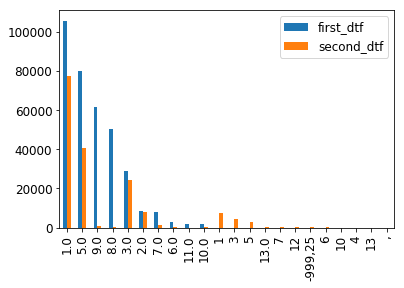

In [88]:
plt_dtf = pd.DataFrame([dtf_first['LIT'].value_counts(), dtf_second['LIT'].value_counts()]).T
plt_dtf.columns = ['first_dtf', 'second_dtf']
# plt_dtf.index = map(lambda x: lithology[int(x)], plt_dtf.index)
plt_dtf.plot(kind='bar')

7 -- Точно уголь

In [183]:
plt_dtf.T

песчаник  Аргиллит алевритовый  Аргиллит  Гравелит   алевролит  \
first_dtf   105632.0                8555.0   28757.0        NaN    79680.0   
second_dtf   31961.0                7742.0    3560.0       67.0    20651.0   

            Аргиллит углистый   Уголь  Супесь   Суглинок  \
first_dtf              2926.0  7821.0  50142.0   61533.0   
second_dtf              148.0   349.0      NaN     356.0   

            Валунно-галечные отложения   песок  
first_dtf                       1969.0  2076.0  
second_dtf                         NaN     NaN

## Визуализация первого месторождения с помощью tnse

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
dtf_first.columns

Index(['BK', 'DS', 'Dept', 'GGK(p)', 'GR', 'KS', 'LIT', 'REZ'], dtype='object')

In [37]:
scaler = StandardScaler()
x_data = scaler.fit_transform(dtf_first.dropna()[['BK', 'GGK(p)', 'GR']])

In [38]:
decomp = TSNE(verbose=0.5)
# decomp = PCA(n_components=2)
decomped_x = decomp.fit_transform(x_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 41447 samples in 0.043s...
[t-SNE] Computed neighbors for 41447 samples in 1.161s...
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.654694
[t-SNE] Error after 1000 iterations: 1.780939


In [394]:
dtf_first.dropna().LIT.values, decomped_x

(array([ 1.,  1.,  1., ...,  1.,  1.,  1.]),
 array([[-18.70180321,  74.25946045],
        [ 27.37760925,  75.42448425],
        [ 25.98553085,  75.06437683],
        ..., 
        [-75.94229126, -31.71473694],
        [-28.46595573,  11.27650642],
        [ 20.42467499, -16.33847046]], dtype=float32))

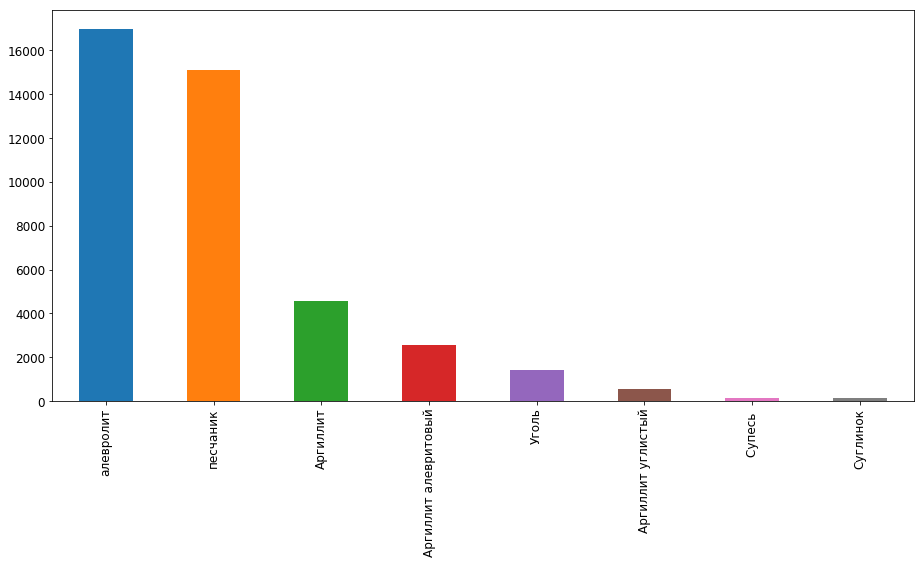

In [21]:
plt.figure(figsize=(13, 8))
dtf_first.dropna().LIT.apply(lambda x: lithology[x]).value_counts().plot(kind='bar')
plt.tight_layout()
plt.savefig('log-images/first-deposit-target-values.png')

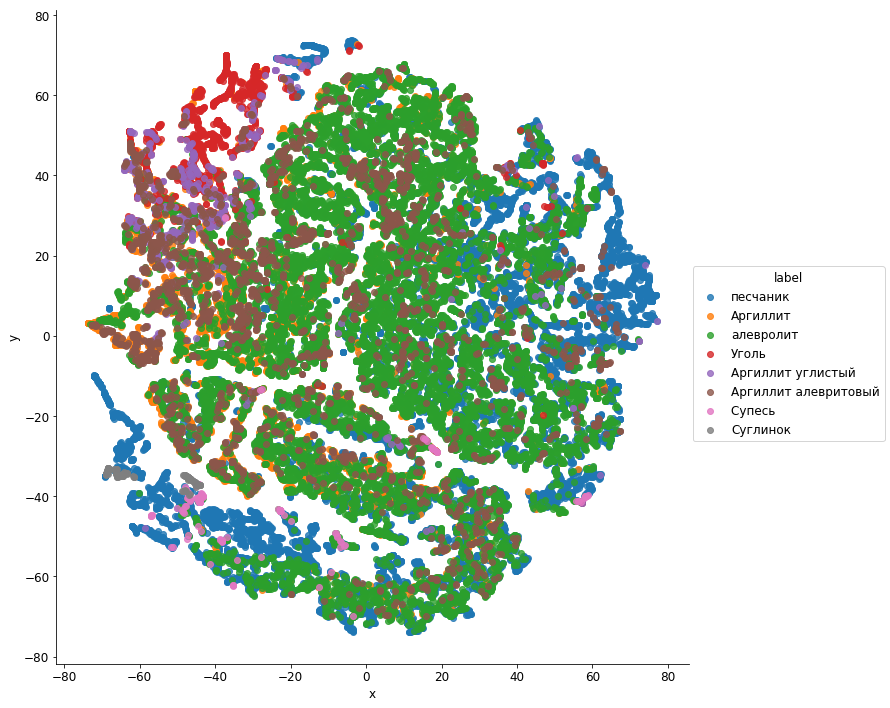

In [32]:
sns.lmplot(x='x', y='y', hue='label', data=pd.DataFrame(np.hstack((decomped_x, 
                                                                   dtf_first.dropna().LIT.apply(lambda x: lithology[x]).values.reshape(-1, 1)))[dtf_first.dropna().Dept > 100],
                                                           columns=['x', 'y', 'label']),
          fit_reg=False, size=10)
plt.savefig('log-images/decomposition/decomposition-of-first-deposit-scaled-feats-bk-ggk-gr-ks.png')

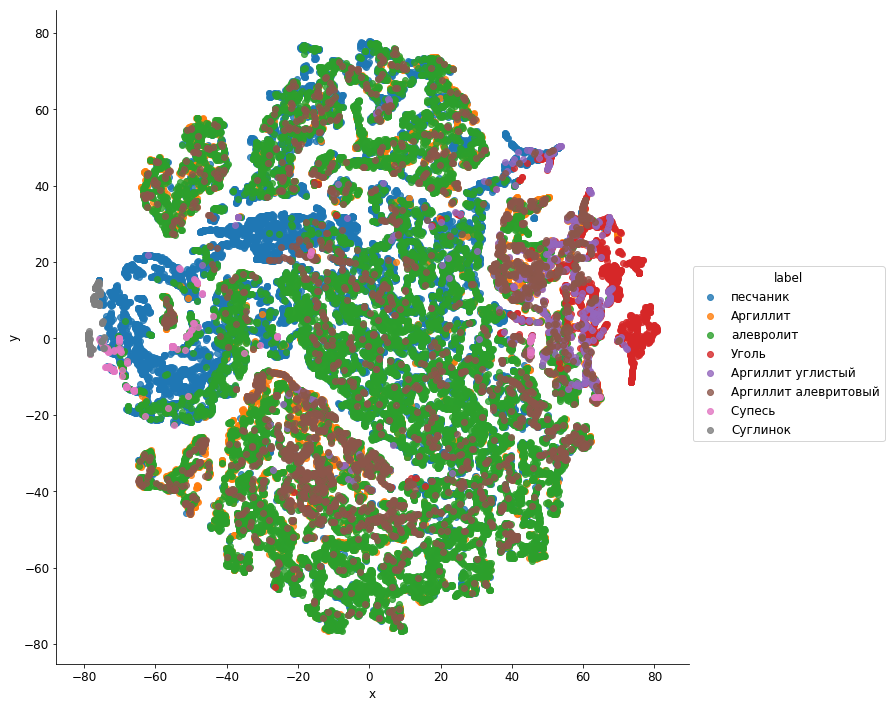

In [39]:
sns.lmplot(x='x', y='y', hue='label', data=pd.DataFrame(np.hstack((decomped_x, 
                                                                   dtf_first.dropna().LIT.apply(lambda x: lithology[x]).values.reshape(-1, 1)))[dtf_first.dropna().Dept > 100],
                                                           columns=['x', 'y', 'label']),
          fit_reg=False, size=10)
plt.savefig('log-images/decomposition/decomposition-of-first-deposit-scaled-feats-bk-ggk-gr.png')

In [ ]:
sns.lmplot(x='x', y='y', hue='label', data=pd.DataFrame(np.hstack((decomped_x, 
                                                                   dtf_first.dropna().LIT.apply(lambda x: lithology[x]).values.reshape(-1, 1)))[dtf_first.dropna().Dept > 100],
                                                           columns=['x', 'y', 'label']),
          fit_reg=False, size=10)
plt.savefig('log-images/decomposition/decomposition-of-secind-deposit-scaled-feats-bk-ggk-gr-ks.png')

# Обучение

## Baseline algorithm (count classifier)
Идея: Найти минимумальные и максимальные значения для значений методов\*. Затем, на отложенной скважине посчитать попадание значений методов в полученные минимумы и максимумы.

\*Метод -- это метод оценки литологии (Гамма каротаж, ПС, etc.)

In [155]:
def count_classifier(train_dtf, with_descr=False):
    """
    Train simple count classifier. Finds (min, max) interval for lithologies
    """
    lit_dict_descr = dict()
    lit_dict = dict()
    for lit in train_dtf.dropna().LIT.unique():
        if not pd.isnull(lit):
            descr = train_dtf.dropna()[train_dtf.dropna().LIT == lit].describe()
            intervals = dict()
            for v in descr.columns:
                intervals[v] = (descr[v]['min'], descr[v]['max'])
            lit_dict_descr[lithology[lit]] = intervals
            lit_dict[lit] = intervals
    if with_descr:
        return pd.DataFrame(lit_dict_descr)
    else:
        return pd.DataFrame(lit_dict)
 
def in_interval(value, vals):
    """
    check if value between values
    """
    return int(vals[0] <= value <= vals[1])

def predict(clf_dtf, X, threshold=0):
    # Список для сохранения вероятностей
    probs = []
    # Порог для "вероятности"
    threshold = 0
    for row in X.dropna().iterrows():
        dtf_ = pd.DataFrame(columns=[k for k in clf_dtf.keys()], 
                            index=X.columns)
        for it, val in row[1].items():
            if it in clf_dtf.index:
    #             Проверка, входит ли значение метода в интервал
                mask = clf_dtf.loc[it].apply(lambda x : in_interval(val, x))
                dtf_.loc[it] = mask
        dtf_.dropna(inplace=True)
    #     Считаем, для каждой литологии, сколько методов попали в интервал
        prob = dtf_.mean(axis=0)
    #     Отсекаем литологии ниже заданого порога
        prob_actual = prob[prob >= threshold]
        probs.append(prob_actual)
    return probs

## Разбиение на train/dev/test sets

### Отсутвующие методы 

In [40]:
methods = ['Dept', 'GGK(p)', 'DS', 'GR', 'BK', 'KS', 'REZ', 'LIT', 'DT']

In [ ]:
for k, dtf in dtfs_second.items():
    tf_list = [str(k)]
    for m in methods:
        if m in dtf.columns:
            tf_list.append('<font size="2" color="green">Yes</font>')
        else:
            tf_list.append('<font size="2" color="red">No</font>')
    print('|' + '|'.join(tf_list) + '|')

Предоставленные данные имеют такуют специфику, что каждая скважина уникальна: В одной скважине могли использоваться одни методы каротажа, в другой другие.

Для понимания ситуции, мы сделали следющую таблицу:

По строкам идут номера скважин, по столбцам, методы и атрибуты скважин.
- Dept -- глубина
- GGK(p) -- Гамма-гамма каротаж
- DS -- Диаметр скважины
- GR -- Гамма каротаж
- DK -- Боковой каротаж
- KS -- Кажущееся сопротивление
- REZ -- Элестрическое сопротивление в скважине (или вроде того)
- LIT -- Номер литологии
- DT -- Аккустический каротаж

| well/method | Dept | GGK(p) | DS | GR | BK | KS | REZ | LIT | DT |
|:-----------:|:----:|:------:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|
|1787|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|628|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1790-1|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1399|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|690|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1731|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1790-3|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1790-4|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1801|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1093|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|210|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|788|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1804|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1779|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1462|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|809|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|639|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|875|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1763|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1742|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|822|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1790-2|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|919|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|1725|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-751|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-754|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-745|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-741|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-743|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-742|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-752|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|
|UK-758|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-740|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-762|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-746-1|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-739|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-749|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-757-1|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-753|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-752-1|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-757|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|
|UK-744|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-756|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-750|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-761|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-738|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-760|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-746|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|
|UK-748|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-759|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-755|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|
|UK-747|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|<font size="2" color="green">Yes</font>|<font size="2" color="red">No</font>|

Как видно в таблице, есть методы, которые всегда используются:
- [GGK, GR, REZ], также, за исключением одного случая, используется BK.
- DT Используется только в одном месторождении и то не во всех случаях (что странно, на самом деле)
- KS Также исопльзуется, но далеко не во всех скважинах.

Поскольку количество фичей в модели, которую мы будем обучать, фиксировано, то имеет смысл рассмотреть аппроксимацию отсутствующих методов, поскольку у нас есть два варианта работы с отсутвующими фичами:
- Вообще не рассматривать их при построении модели
- Заполнить отсутвующие значения каким-нибудь методом
    - Средним по скважинам
    - "Нулевым" значением
    - Аппроксимировать значение

### Выборка без отсутвующих методов

Пусть одна скважина в первом месторождении будет тестовая, а второе месторождение будет валидационным

In [131]:
seed = 30

In [302]:
X_data = ['GR', 'BK', 'GGK(p)', 'DS', 'REZ', 'Dept']
y_data = ['LIT']

In [303]:
excluded_dtfs = ['875']
np.random.seed(seed)
test_dtf_number = np.random.choice([k for k in dtfs_first.keys() if k != excluded_dtfs[0]])
excluded_dtfs.append(test_dtf_number)
print(excluded_dtfs[1])

1742


In [304]:
train_data = pd.concat([d for k, d in dtfs_first.items() if k not in excluded_dtfs], ignore_index=True)
test_data = pd.concat([d for k, d in dtfs_second.items() if k not in excluded_dtfs], ignore_index=True)
train_data[X_data + y_data].dropna().shape, test_data[X_data + y_data].dropna().shape

((199256, 7), (62782, 7))

In [305]:
# Берем данные глубже 100 метров, потому что см. анализ данных
x_train = train_data[train_data.Dept > 100][X_data + y_data].dropna()[X_data]
x_train.drop('Dept', inplace=True, axis=1)
y_train = train_data[train_data.Dept > 100][X_data + y_data].dropna()[y_data]
x_train.shape, y_train.shape

((193866, 5), (193866, 1))

In [306]:
x_test = test_data[test_data.Dept > 100][X_data + y_data].dropna()[X_data]
x_test.drop('Dept', inplace=True, axis=1)
y_test = test_data[test_data.Dept > 100][X_data + y_data].dropna()[y_data]
x_test.shape, y_test.shape

((30119, 5), (30119, 1))

#### Обучение методов

##### Random Forest

In [307]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [317]:
params = {'n_estimators':10, 
          'max_depth':10, 
          'class_weight':'balanced',
          'random_state' : seed}
clf = RandomForestClassifier(**params)
clf.fit(x_train, y_train)
clf.score(x_train, y_train), clf.score(x_test, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(0.65721684049807594, 0.56648627112453931)

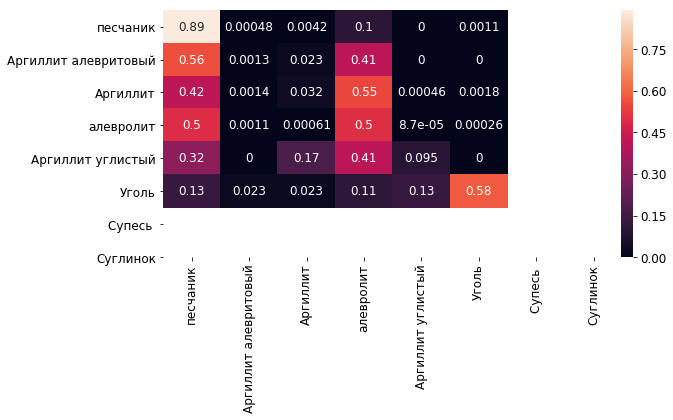

In [318]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='RandomForest_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

##### LogisticRegression

In [301]:
from sklearn.preprocessing import StandardScaler

In [311]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [312]:
params = {'class_weight':'balanced',
          'random_state' : seed}
clf = LogisticRegression(**params)
clf.fit(x_train_scaled, y_train)
clf.score(x_train_scaled, y_train), clf.score(x_test_scaled, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.57067252638420352, 0.5512467213386899)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


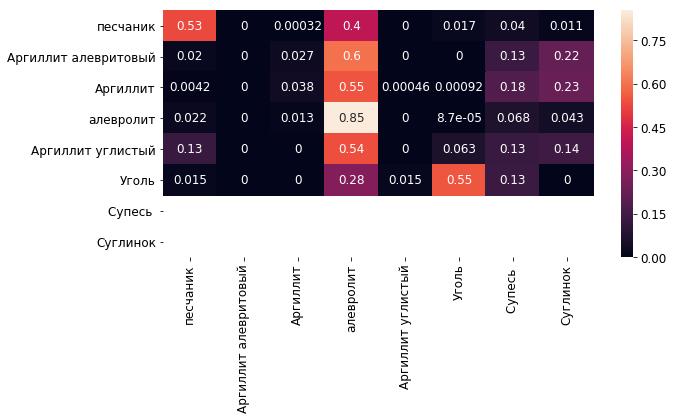

In [313]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test_scaled)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='LogisticRegression_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

##### Count classifier

In [227]:
x_train['LIT'] = y_train
clf_dtf = count_classifier(x_train)
probs = predict(pd.DataFrame(clf_dtf).loc[X_data[:-1]], x_test)
x_train.drop('LIT', inplace=True, axis=1)

In [228]:
threshold = 5/6
count = 0
total = 0
Y_true = []
Y_pred = []
for y_true_val, y_pred in zip(y_test.values, probs):
    total += 1
    if len(y_pred) > 0:
        count += (y_true_val in y_pred[y_pred > threshold].values)
        Y_pred.append(y_pred.argmax())
    else:
        Y_pred.append(-1)
    Y_true.append(y_true_val)
print(count/total)

0.1870580032537601


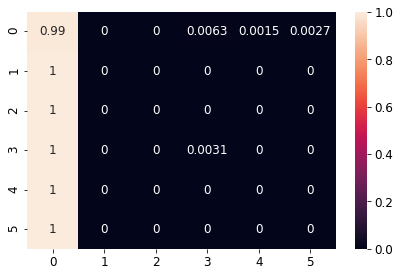

In [229]:
plot_conusion_matrix(confusion_matrix(Y_true, Y_pred), save_fig=False)

##### Выводы:
Результаты классификации с помощью Random Forest и Logistic Regression показывают, что необходимо использовать понижение количества наблюдаемых занчений (Under sampling)

Стоит добавить:
- Кросс валидацию с one deposit out;
- Under sampling
- Попробовать альтернативные методы классификаци

Count classifier показывает не очень впечатляющие результаты. Возможные причины проблемы:
- Шумовые значения
- Использование лишних данных (DS, REZ не столь важны, как GK или GGK)

### Заполнить пропущенные методы и значнеия средним по датасету

In [131]:
seed = 30

In [376]:
X_data = ['GR', 'BK', 'KS', 'GGK(p)', 'DS', 'REZ', 'Dept']
X_test_data = ['GR', 'GGK(p)', 'DS', 'REZ', 'Dept']
y_data = ['LIT']

In [377]:
excluded_dtfs = ['875']
np.random.seed(seed)
test_dtf_number = np.random.choice([k for k in dtfs_first.keys() if k not in excluded_dtfs])
excluded_dtfs.append(test_dtf_number)
print(excluded_dtfs[1])

1742


In [378]:
train_data = pd.concat([d for k, d in dtfs_first.items() if k not in excluded_dtfs], ignore_index=True)
test_data = pd.concat([d for k, d in dtfs_second.items() if k not in excluded_dtfs], ignore_index=True)
train_data[X_data].shape, test_data[X_test_data].shape

((331632, 7), (65457, 5))

In [379]:
# Берем данные глубже 100 метров, потому что см. анализ данных
x_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][X_data]
x_train.drop('Dept', inplace=True, axis=1)
y_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][y_data]
x_train.shape, y_train.shape

((222724, 6), (222724, 1))

In [380]:
x_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][X_test_data]
x_test.drop('Dept', inplace=True, axis=1)
y_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][y_data]
x_test.shape, y_test.shape

((30368, 4), (30368, 1))

In [382]:
fill_values = x_train.describe().loc['mean']
x_train.fillna(fill_values, inplace=True, axis=0)
print()

In [383]:
x_test['KS'] = np.nan
x_test['BK'] = np.nan
x_test.fillna(fill_values, inplace=True, axis=0)
print()

#### Обучение методов

##### Random Forest

In [384]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [385]:
params = {'n_estimators':10, 
          'max_depth':12, 
          'class_weight':'balanced',
          'random_state' : seed}
clf = RandomForestClassifier(**params)
clf.fit(x_train, y_train)
clf.score(x_train, y_train), clf.score(x_test, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(0.7045581077926043, 0.52433482613277138)

Забавня зависимость: Если брать максимальную глубину 10, то получается очень сильный underfit (0.04), а если брать 12, то точность возрастает до 0.52

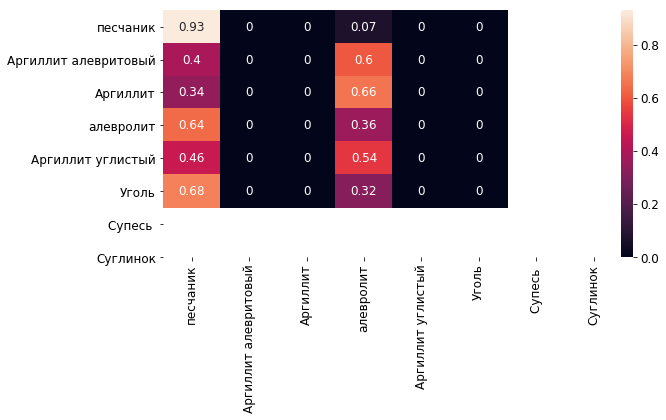

In [386]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='RandomForest_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

Заполение средними значениями дает не очень хорошие результаты. Скорее всего, дело в том, что: 
1. на разной глубине разные значения методов; 
2. Мы добавляем еще больше больше лишних значений (в частности песка), поэтому разумно было бы использовать undersampling 

##### LogisticRegression

In [337]:
from sklearn.preprocessing import StandardScaler

In [338]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [339]:
params = {'class_weight':'balanced',
          'random_state' : seed}
clf = LogisticRegression(**params)
clf.fit(x_train_scaled, y_train)
clf.score(x_train_scaled, y_train), clf.score(x_test_scaled, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.54122591189095026, 0.0042808219178082189)

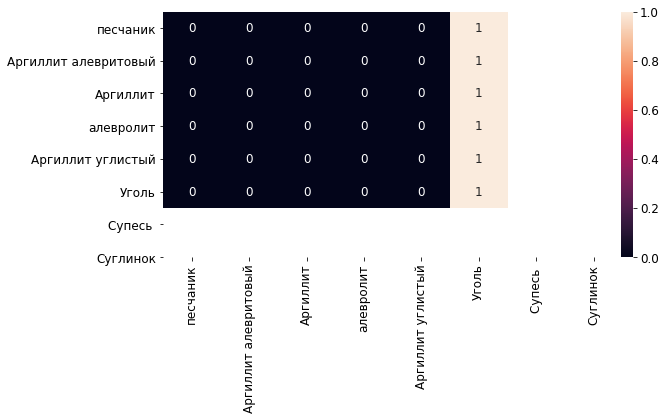

In [340]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test_scaled)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='LogisticRegression_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

Логистическая регрессия также показывает плохие результаты :(

### Заполнить пропущенные методы и значнеия "нулями"

In [342]:
seed = 30

In [343]:
X_data = ['GR', 'BK', 'KS', 'GGK(p)', 'DS', 'REZ', 'Dept']
X_test_data = ['GR', 'GGK(p)', 'DS', 'REZ', 'Dept']
y_data = ['LIT']

In [344]:
excluded_dtfs = ['875']
np.random.seed(seed)
test_dtf_number = np.random.choice([k for k in dtfs_first.keys() if k not in excluded_dtfs])
excluded_dtfs.append(test_dtf_number)
print(excluded_dtfs[1])

1742


In [345]:
train_data = pd.concat([d for k, d in dtfs_first.items() if k not in excluded_dtfs], ignore_index=True)
test_data = pd.concat([d for k, d in dtfs_second.items() if k not in excluded_dtfs], ignore_index=True)
train_data[X_data].shape, test_data[X_test_data].shape

((331632, 7), (65457, 5))

In [369]:
# Берем данные глубже 100 метров, потому что см. анализ данных
x_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][X_data]
x_train.drop('Dept', inplace=True, axis=1)
y_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][y_data]
x_train.shape, y_train.shape

((222724, 6), (222724, 1))

In [370]:
x_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][X_test_data]
x_test.drop('Dept', inplace=True, axis=1)
y_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][y_data]
x_test.shape, y_test.shape

((30368, 4), (30368, 1))

In [371]:
x_train.fillna(-999.25, inplace=True)
print()

In [372]:
x_test['KS'] = np.nan
x_test['BK'] = np.nan
x_test.fillna(-999.25, inplace=True)
print()

#### Обучение методов

##### Random Forest

In [373]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [374]:
params = {'n_estimators':10, 
          'max_depth':15, 
          'class_weight':'balanced',
          'random_state' : seed}
clf = RandomForestClassifier(**params)
clf.fit(x_train, y_train)
clf.score(x_train, y_train), clf.score(x_test, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(0.79815376879007205, 0.41570073761854581)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


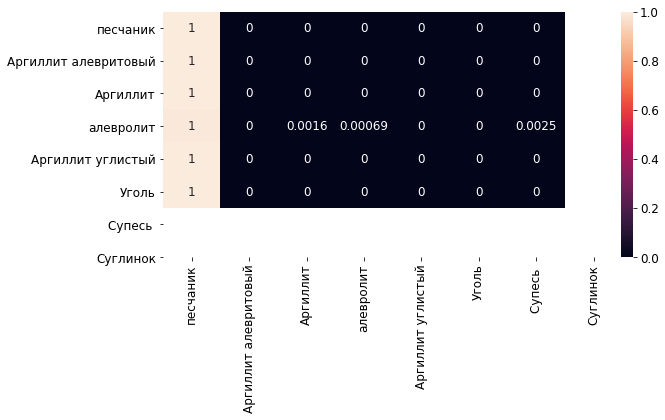

In [375]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='RandomForest_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

Заполение "нулями" вообще не работает хд

Поэтому для них надо искать замену либо вообще их удалять

##### LogisticRegression

In [365]:
from sklearn.preprocessing import StandardScaler

In [366]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [367]:
params = {'class_weight':'balanced',
          'random_state' : seed}
clf = LogisticRegression(**params)
clf.fit(x_train_scaled, y_train)
clf.score(x_train_scaled, y_train), clf.score(x_test_scaled, y_test)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.45150949156803938, 0.4130663856691254)

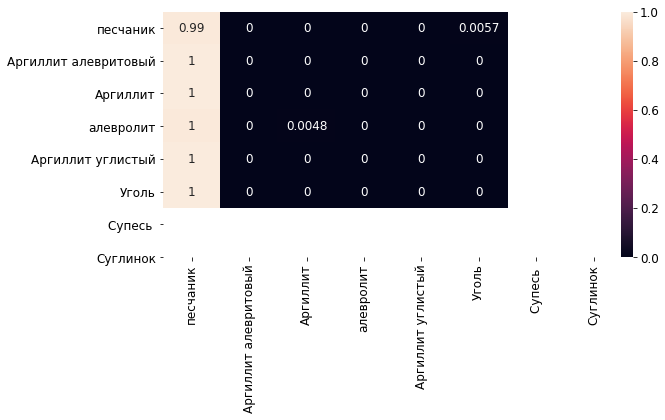

In [368]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test, clf.predict(x_test_scaled)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='LogisticRegression_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

no comment

### Заполнение пропущенных значений аппроксимацией

In [433]:
seed = 32

##### Построение аппроксимирующей модели

In [434]:
np.random.seed(seed)
deposits_with_all_methods = ['1093', '1462', '1763', '210']
test_reg_deposit = np.random.choice(deposits_with_all_methods)
train_reg_deposits = deposits_with_all_methods
train_reg_deposits.remove(test_reg_deposit)

In [435]:
train_reg_data = pd.concat([dtfs_first[k] for k in train_reg_deposits], ignore_index=True).dropna()
test_reg_data = dtfs_first[test_reg_deposit].dropna()
train_reg_data.shape, test_reg_data.shape

((30320, 8), (11127, 8))

In [494]:
train_reg_data = train_reg_data[train_reg_data.Dept > 100]
test_reg_data = test_reg_data[test_reg_data.Dept > 100]

In [457]:
from itertools import combinations

def find_missing(combos, all_values):
    """Handy function to find target variable based on combinations"""
    for target in all_values:
        if target not in combos:
            return target

In [487]:
from copy import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

method: GGK(p) train score = 0.5802056483699967, test score = -0.5145779505873616


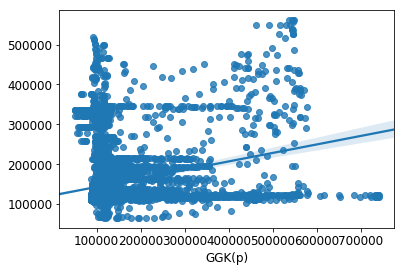

method: KS train score = 0.9037521059510103, test score = 0.34813833653230986


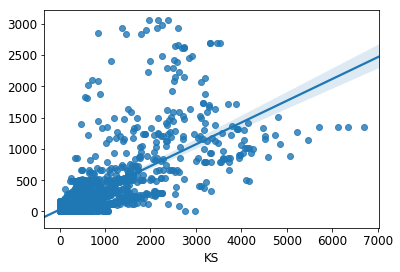

method: BK train score = 0.9032364176778256, test score = 0.3860972609584986


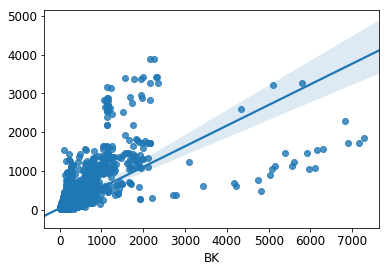

method: GR train score = 0.6025974603727099, test score = -0.07037775293465542


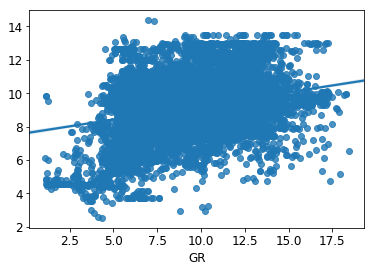

In [543]:
to_model = ['GR', 'BK', 'KS', 'GGK(p)']
models_3 = dict()

params = {'n_estimators':10, 
          'max_depth':8, 
          'random_state' : seed,
          'criterion':'mse'}

for variables in combinations(to_model, 3):
    variables = [v for v in variables]
    target_var = find_missing(variables, to_model)
    x_reg_train = train_reg_data[variables]
    y_reg_train = train_reg_data[target_var]
    
    scaler = StandardScaler()
    x_reg_train = scaler.fit_transform(x_reg_train)
    
    x_reg_test = test_reg_data[variables]
    y_reg_test = test_reg_data[target_var]
    
    x_reg_test = scaler.fit_transform(x_reg_test)
    
    reg = RandomForestRegressor(**params)
    reg.fit(x_reg_train, y_reg_train)
    print('method: {} train score = {}, test score = {}'.format(target_var, 
                                                                reg.score(x_reg_train, y_reg_train), 
                                                                reg.score(x_reg_test, y_reg_test)))
    sns.regplot(y_reg_test, reg.predict(x_reg_test))
    plt.show()
    models_3[(target_var, tuple(sorted(variables)))] = (copy(scaler), copy(reg))

In [542]:
to_model = ['GR', 'BK', 'KS', 'GGK(p)']
models_2 = dict()

params = {'n_estimators':10, 
          'max_depth':8, 
          'random_state' : seed,
          'criterion':'mse'}

for variables in combinations(to_model, 2):
    for target_var in to_model:
        if target_var not in variables:
            variables = [v for v in variables]
            x_reg_train = train_reg_data[variables]
            y_reg_train = train_reg_data[target_var]

            scaler = StandardScaler()
            x_reg_train = scaler.fit_transform(x_reg_train)

            x_reg_test = test_reg_data[variables]
            y_reg_test = test_reg_data[target_var]

            x_reg_test = scaler.fit_transform(x_reg_test)

            reg = RandomForestRegressor(**params)
            reg.fit(x_reg_train, y_reg_train)
            print('method: {} based on {} train score = {}, test score = {}'.format(target_var,
                                                                            variables,        
                                                                            reg.score(x_reg_train, y_reg_train), 
                                                                            reg.score(x_reg_test, y_reg_test)))
        #     sns.regplot(y_reg_test, reg.predict(x_reg_test))
        #     plt.show()
            models_2[(target_var, tuple(sorted(variables)))] = (copy(scaler), copy(reg))

method: KS based on ['GR', 'BK'] train score = 0.821730633582307, test score = 0.33611910890883856
method: GGK(p) based on ['GR', 'BK'] train score = 0.4553978175071438, test score = -0.09233049075490296
method: BK based on ['GR', 'KS'] train score = 0.8719006536386279, test score = -0.4447136511092815
method: GGK(p) based on ['GR', 'KS'] train score = 0.5738986178429137, test score = -0.33711183632457864
method: BK based on ['GR', 'GGK(p)'] train score = 0.729528573910184, test score = 0.2216531806322788
method: KS based on ['GR', 'GGK(p)'] train score = 0.6588285877236999, test score = 0.1158128365372979
method: GR based on ['BK', 'KS'] train score = 0.4938703653940949, test score = -0.7251656950464977
method: GGK(p) based on ['BK', 'KS'] train score = 0.5295153724716111, test score = -1.0808344847885474
method: GR based on ['BK', 'GGK(p)'] train score = 0.5644170774050185, test score = 0.0777410053137283
method: KS based on ['BK', 'GGK(p)'] train score = 0.8791367211021193, test sco

In [556]:
to_model = ['GR', 'BK', 'KS', 'GGK(p)']
models_1 = dict()

params = {'n_estimators':10, 
          'max_depth':None, 
          'random_state' : seed,
          'criterion':'mse'}

for variables in to_model:
    for target_var in to_model:
        if target_var != variables:
            x_reg_train = train_reg_data[variables].values.reshape(-1, 1)
            y_reg_train = train_reg_data[target_var].values.reshape(-1, 1)

            scaler = StandardScaler()
            x_reg_train = scaler.fit_transform(x_reg_train).reshape(-1, 1)

            x_reg_test = test_reg_data[variables].values.reshape(-1, 1)
            y_reg_test = test_reg_data[target_var].values.reshape(-1, 1)

            x_reg_test = scaler.fit_transform(x_reg_test).reshape(-1, 1)

            reg = RandomForestRegressor(**params)
            reg.fit(x_reg_train, y_reg_train.ravel())
            print('method: {} based on {} train score = {}, test score = {}'.format(target_var,
                                                                            variables,        
                                                                            reg.score(x_reg_train, y_reg_train.ravel()), 
                                                                            reg.score(x_reg_test, y_reg_test.ravel())))
        #     sns.regplot(y_reg_test, reg.predict(x_reg_test))
        #     plt.show()
            models_1[(target_var, tuple([variables],))] = (copy(scaler), copy(reg))

method: BK based on GR train score = 0.6466396313556235, test score = -0.259066431372851
method: KS based on GR train score = 0.5472100596204397, test score = 0.026707691959584445
method: GGK(p) based on GR train score = 0.38937484162239655, test score = -0.1342401315047177
method: GR based on BK train score = 0.686791122808751, test score = -0.4698546111524812
method: KS based on BK train score = 0.9050646475754561, test score = 0.35542109843315006
method: GGK(p) based on BK train score = 0.7444559220436309, test score = -0.40962201238824253
method: GR based on KS train score = 0.6525027021271049, test score = -0.956137042010324
method: BK based on KS train score = 0.8714855385172976, test score = 0.08628078150391383
method: GGK(p) based on KS train score = 0.7906770323965364, test score = -0.9340833382788633
method: GR based on GGK(p) train score = 0.7740797505098062, test score = -0.10068249064396671
method: BK based on GGK(p) train score = 0.8243323111625926, test score = -0.190956

По Графиками, а также коеффициентам детерминации видно, что можно моделировать интересующие нас, пропущенные, методы каротажа: `BK` и `KS`. `GKK(p)` и `GK` Не столь хорошо моделируются. я Попробвал применить $log(y+1)$, к целевой переменной, это не помогло.

Моделить один метод через другой выглядит не очень здорово, но посмотрим на результаты классификации при добавлении этих значений.

##### Train/test split

In [590]:
seed = 30

In [591]:
X_data = ['GR', 'BK', 'KS', 'GGK(p)', 'DS', 'REZ', 'Dept']
X_test_data = ['GR', 'GGK(p)', 'DS', 'REZ', 'Dept']
y_data = ['LIT']

In [592]:
excluded_dtfs = ['875']
np.random.seed(seed)
test_dtf_number = np.random.choice([k for k in dtfs_first.keys() if k not in excluded_dtfs])
excluded_dtfs.append(test_dtf_number)
print(excluded_dtfs[1])

1742


In [593]:
train_data = pd.concat([d for k, d in dtfs_first.items() if k not in excluded_dtfs], ignore_index=True)
test_data = pd.concat([d for k, d in dtfs_second.items() if k not in excluded_dtfs], ignore_index=True)
train_data[X_data].shape, test_data[X_test_data].shape

((331632, 7), (65457, 5))

In [598]:
def fill_vals(row):
    r = row
    known_methods = []
    unknown_methods = []
    for k in to_model:
        if k in r.keys():
            if np.isnan(r[k]):
                unknown_methods.append(k)
            else:
                known_methods.append(k)
        else:
            unknown_methods.append(k)
    if len(known_methods) == 1:
        for um in unknown_methods:
            x = models_1[(um, tuple(sorted(known_methods)))][0].transform(row[known_methods].values.reshape(1, -1))
            pred = models_1[(um, tuple(sorted(known_methods)))][1].predict(x)
            r[um] = pred[0]
    elif len(known_methods) == 2:
        for um in unknown_methods:
            x = models_2[(um, tuple(sorted(known_methods)))][0].transform(row[known_methods].values.reshape(1, -1))
            pred = models_2[(um, tuple(sorted(known_methods)))][1].predict(x.reshape(1, -1))
            r[um] = pred[0]
    elif len(known_methods) == 3:
        for um in unknown_methods:
            x = models_3[(um, tuple(sorted(known_methods)))][0].transform(row[known_methods].values.reshape(1, -1))
            pred = models_3[(um, tuple(sorted(known_methods)))][1].predict(x.reshape(1, -1))
            r[um] = pred[0]
    return r

In [595]:
# Берем данные глубже 100 метров, потому что см. анализ данных
x_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][X_data]
x_train.drop('Dept', inplace=True, axis=1)
y_train = train_data.iloc[train_data[train_data.Dept > 100][y_data].dropna().index][y_data]
x_train.shape, y_train.shape

((222724, 6), (222724, 1))

In [596]:
x_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][X_test_data]
x_test.drop('Dept', inplace=True, axis=1)
y_test = test_data.iloc[test_data[test_data.Dept > 100][y_data].dropna().index][y_data]
x_test.shape, y_test.shape

((30368, 4), (30368, 1))

In [600]:
x_train = x_train.apply(fill_vals, axis=1)
print()

In [599]:
if 'KS' not in x_test.columns:
    x_test['KS'] = np.nan    
if 'BK' not in x_test.columns:
    x_test['BK'] = np.nan    
x_test = x_test.apply(fill_vals, axis=1)
print()

##### Обучение методов

###### Random Forest

In [373]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [612]:
params = {'n_estimators':10, 
          'max_depth':None, 
          'class_weight':'balanced',
          'random_state' : seed}
clf = RandomForestClassifier(**params)
clf.fit(x_train.dropna(), y_train.loc[x_train.dropna().index])
print(clf.score(x_train.dropna(), y_train.loc[x_train.dropna().index]), 
     clf.score(x_test.dropna(), y_test.loc[x_test.dropna().index]))

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.995618641779 0.545493533914


/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


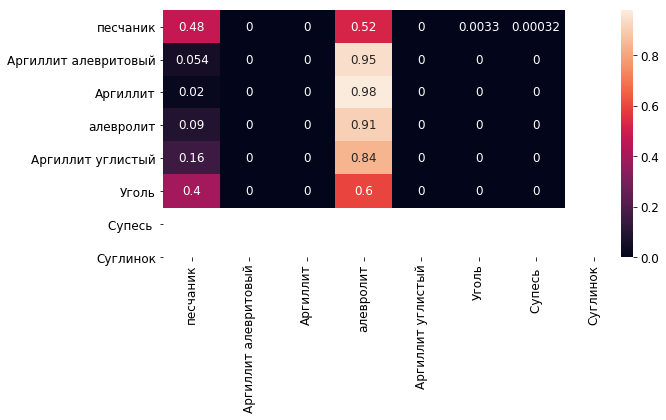

In [613]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test.loc[x_test.dropna().index], clf.predict(x_test.dropna())), ticks=ticks, save_path='log-images/predictions/',
                     file_name='RandomForest_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

Заполение "нулями" вообще не работает хд

Поэтому для них надо искать замену либо вообще их удалять

###### LogisticRegression

In [614]:
from sklearn.preprocessing import StandardScaler

In [615]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.dropna())
x_test_scaled = scaler.transform(x_test.dropna())

In [618]:
params = {'class_weight':'balanced',
          'random_state' : seed}
clf = LogisticRegression(**params)
clf.fit(x_train_scaled, y_train.loc[x_train.dropna().index])
clf.score(x_train_scaled, y_train.loc[x_train.dropna().index]), clf.score(x_test_scaled, y_test.loc[x_test.dropna().index])

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.54366353569606574, 0.0013855898653998416)

/Volumes/Media/Documents/Programming/Git/(DD)-gitlab-projects/carrot/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


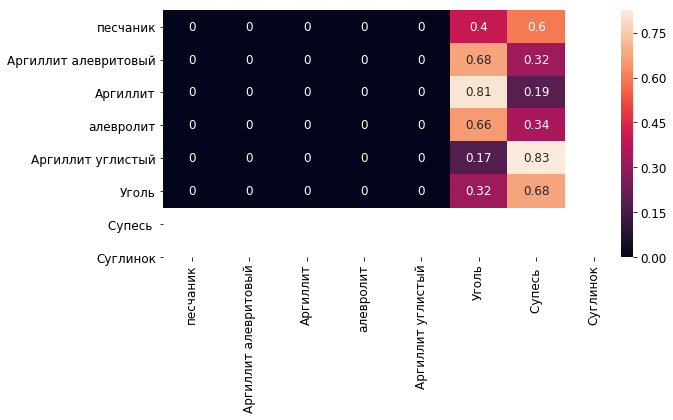

In [620]:
ticks = [lithology[num] for num in [1, 2, 3, 5, 6, 7, 8, 9]]
plt.figure(figsize=(10, 6))
plot_conusion_matrix(confusion_matrix(y_test.loc[x_test.dropna().index], clf.predict(x_test_scaled)), ticks=ticks, save_path='log-images/predictions/',
                     file_name='LogisticRegression_' + '_'.join(['{}-{}'.format(k, v)for k, v in params.items()]))

###### Выводы:
К сожалению, магия не случилась и точность не повысислась.

Но тут может быть другая проблема быть причиной:
- При моделировании методов, коефиициент детерминации во многих случаях очень маленький, поэтому имеет смысл обратить на это внимание.
    - Поиграть с масштабом данных;
    - Попробовать иные методы нелинейной регрессии.
- Мы также добавляем еще больше лишних значений для и так большого количества литологий, мб в этом проблема.

## Изучение важности KS

In [43]:
from itertools import chain

In [46]:
dtfs_with_ks = {name:dtf for name, dtf in chain(dtfs_first.items(), dtfs_second.items()) if 'KS' in dtf.columns}

In [94]:
for n, dtf in dtfs_with_ks.items():
    check_values_for_str(dtf, 'LIT', n)

UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,25
UK-757-1 -999,

In [63]:
test_dtf_number = np.random.choice([k for k in dtfs_with_ks.keys()])
test_dtf_number

'UK-741'

In [70]:
dtf_with_ks = pd.concat([dtf for n, dtf in dtfs_with_ks.items() if n != test_dtf_number])[['KS', 'LIT']]

In [71]:
dtf_with_ks.shape, dtf_with_ks.dropna().shape

((177618, 2), (145530, 2))

In [74]:
X = dtf_with_ks.dropna()['KS'].values.reshape((-1, 1))
Y = dtf_with_ks.dropna()['LIT'].values.reshape((-1, 1))

In [77]:
X.shape, Y.shape

((145530, 1), (145530, 1))

In [78]:
x_test = dtfs_with_ks[test_dtf_number][['KS', 'LIT']].dropna()['KS'].values.reshape((-1, 1))
y_test = dtfs_with_ks[test_dtf_number][['KS', 'LIT']].dropna()['LIT'].values.reshape((-1, 1))

### Классификация без скалирования

#### Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
clf = RandomForestClassifier()
clf.fit(X, Y)

/home/nikita/projects/carrot/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ValueError: Unknown label type: 'unknown'

In [83]:
from collections import Counter

In [90]:
Counter(Y.reshape(-1).tolist())

Counter({',': 1,
         '-999,25': 14,
         '1': 7654,
         1.0: 60496,
         '10': 68,
         '12': 136,
         '13': 1,
         13.0: 251,
         2.0: 2595,
         '3': 4413,
         3.0: 25166,
         '5': 2679,
         5.0: 37523,
         '6': 113,
         6.0: 839,
         '7': 188,
         7.0: 2714,
         8.0: 361,
         9.0: 318})